# Importing Libraries

In [1]:
import qiskit

In [1040]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z, CX
from qiskit.quantum_info.operators import Operator, Pauli

In [101]:
# optimizers
import scipy
from scipy import linalg
from scipy.linalg import cossin
from scipy.stats import unitary_group
import openql as ql
import quantum_decomp

In [4]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.providers.aer.noise import NoiseModel

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Jakarta Machine Import

In [5]:
#provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#backend = provider.get_backend('ibmq_jakarta')

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
quito_noise_model = NoiseModel.from_backend(provider.get_backend('ibmq_quito'))
sim_noisy_quito = QasmSimulator.from_backend(provider.get_backend('ibmq_quito'), noise_model = quito_noise_model)

In [6]:
token = '6d5832e8a1d529cf3f0b19947f07d2b9b8134f5bc317337efc14f7802b083a370d8080acfcd80a94a4716da1d5a2d5637956199adf059ceb9fd5812d6231a46b'

In [7]:
IBMQ.save_account(token, overwrite=True)

In [1]:
provider = IBMQ.load_account()

NameError: name 'IBMQ' is not defined

In [9]:
provider.backends()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

In [10]:
jakarta = provider.get_backend('ibmq_jakarta')

In [11]:
jbasis = jakarta.configuration().basis_gates

In [1727]:
jmap = jakarta.configuration().coupling_map

In [12]:
properties = jakarta.properties()

#Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

# Defining the Hamiltonian Model

In [13]:
# IBM code, Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [14]:
# IBM code, Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_12():

    # Sum interactions
    H = (X^X) + (Y^Y) + (Z^Z)
    # Return Hamiltonian
    return H

In [15]:
def U_12(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_12()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [34]:
#IBM code

# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

# Quantum Shannon Decomposition and Unitary Synthesis

In [148]:
def schur_decomposition(U):
    
    D, Z = linalg.schur(U, output = 'complex')
    return Z, D

In [149]:
def de_multiplex(a, b):
    
    ab = np.matmul(a, np.matrix(b).getH())
    
    V, T = schur_decomposition(ab)
    d = np.array([np.sqrt(si) for si in np.diagonal(T)])
    W = np.matmul(np.matmul(np.diag(d), np.matrix(V).getH()), b)
        
    return V, np.diag(d), W

In [150]:
# need opt
def multiplex_rotation(uD):
    dim, dim = np.shape(uD)
    num_qubits = int(np.log2(dim))
    
    qr1 = QuantumRegister(num_qubits)
    qc1 = QuantumCircuit(qr1)
    qc1.unitary(np.matrix(uD).getH().dot(np.matrix(uD).getH()), qr1)
    gate = qc1.to_gate().control(1)
    
    qr = QuantumRegister(num_qubits + 1)
    qc = QuantumCircuit(qr)
    qc.append(gate, [qr[-1]] + [qr[i] for i in range(num_qubits)])
    qc.unitary(uD, [qr[i] for i in range(num_qubits)])

    return qc

In [151]:
def gray_angles(theta):
    dim = len(theta)
    n_bits = int(np.log2(dim))
    
    M = np.ones((dim, dim))
    for i in range(dim):
        for j in range(dim):
            exp = binary(i, n_bits).dot(binary(gray_code(j), n_bits))
            M[i][j] = (-1)**exp    
    
    M1 = linalg.inv(M)
    new_angles = np.dot(M1, theta)
    
    return new_angles
    

In [1530]:
def multiplex_diagonal(matrix,  coupling_map = None):
    """
    Input: diagonal, unitary matrix
    Returns: quantum circuit for [matrix, 0], [0, matrix^\dagger]
            Using only 2 qubit gates
    
    """
    
    if not np.all(matrix == np.diag(np.diagonal(matrix))) or not is_unitary(matrix):
        print("Input Matrix is not diagonal!")
        
    dim, dim = np.shape(matrix)
    num_qubits = int(np.log2(dim)) + 1
    
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    # generate angles
    angles = np.array([(np.log(d)/1.j).real for d in np.diagonal(matrix)])
    g_angles = gray_angles(angles)
    
    for i in range(dim):
        
        # rotate last qubit
        angle = g_angles[i]
        qc.rz(- 2 * angle, qr[-1])
        
        if i == dim - 1:
            index = num_qubits - 2
        else:
            index = gray_index(i)
               
        # uncomment here
        if coupling_map:
            lrcx = long_range_cx(num_qubits - 1, index, num_qubits)
            qc.append(lrcx, qr)
        else:
            qc.cx(qr[index], qr[-1])
        
    return qc.to_instruction()   

In [1953]:
def cs_circuit(theta, num_qubits, coupling_map = None):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    # compute angles after gray code transformation
    g_angles = gray_angles(theta)
    
    for i in range(len(theta)):
        
        # rotate last qubit
        angle = g_angles[i]
        qc.ry( 2 * angle, qr[-1])
        
        if i == len(theta) - 1:
            index = num_qubits - 2
        else:
            index = gray_index(i)
                    
        if coupling_map:
            lrcx = long_range_cx(num_qubits - 1, index, num_qubits)
            qc.append(lrcx, qr)
        else:
            qc.cx(qr[index], qr[-1])
                   
    return qc.to_instruction()

In [1954]:
def opt_cs_circuit(theta, num_qubits):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    # compute angles after gray code transformation
    g_angles = gray_angles(theta)
    
    for i in range(len(theta)):
        
        # rotate last qubit
        angle = g_angles[i]
        qc.ry( 2 * angle, qr[-1])
        
        if i == len(theta) - 1:
            index = num_qubits - 2
        else:
            index = gray_index(i)
                    
        qc.cz(qr[index], qr[-1]) 
                   
    return qc.to_instruction()

In [1955]:
n = 3
dim = 2**n

x = U_heis3(-np.pi/2).to_matrix()
#x = U_12(-np.pi/7).to_matrix()
# begin with cos sin decomposition, and separate

x = unitary_group.rvs(dim)

u_multi, csmatrix, v_multi = linalg.cossin(x, p = dim/2, q = dim/2 , separate=False)
u_multi, cs, v_multi = linalg.cossin(x, p = dim/2, q = dim/2 , separate=True)

u1, u2 = u_multi
v1, v2 = v_multi

# next, de-multiplex each side
uV, uD, uW = de_multiplex(u1, u2)
vV, vD, vW = de_multiplex(v1, v2)
        

In [1987]:
x = unitary_group.rvs(dim)
gen_qsd(x).count_ops()

OrderedDict([('u1', 60), ('r', 32), ('cx', 24), ('rz', 8), ('ry', 4)])

In [1956]:
from qiskit.quantum_info import OneQubitEulerDecomposer, TwoQubitBasisDecomposer

def zyz_gate(unitary):
    
    # check if unitary and correct size
    if len(unitary) != 2 :
        print("Cannot decompose larger gates with ZYZ decomposition !")
    if not is_unitary(unitary):
        print("Matrix is not Unitary")
    
    qr = QuantumRegister(1)
    qc = QuantumCircuit(qr)
    
    zyzdecomposer = OneQubitEulerDecomposer("ZYZ")
    a, b, c, d = zyzdecomposer.angles_and_phase(unitary)
        
    qc.rz(c, qr)
    qc.ry(a, qr)
    qc.rz(b, qr)
    
    qc = transpile(qc, optimization_level = 3, basis_gates = jbasis)
    
    return qc.to_instruction()

In [1957]:
def kak1_gate(unitary):
    
    dim, dim = np.shape(unitary)
    if dim == 2:
        return zyz_gate(unitary)
    
    # check if unitary and correct size
    if len(unitary) != 4 :
        print("Cannot decompose larger gates with ZYZ decomposition !")
    if not is_unitary(unitary):
        print("Matrix is not Unitary")
        
    kak1_decomposer = TwoQubitBasisDecomposer(CX, euler_basis = 'ZYZ')
    return kak1_decomposer(unitary).decompose().to_instruction()
    

In [1532]:
def QSD(U, coupling_map = None):
    
    dim, dim = np.shape(U)
    num_qubits = int(np.log2(dim))
    
    if dim == 2:
        return zyz_gate(U)
    
    if dim == 4:
        return kak1_gate(U)
    
    # begin with cos sin decomposition, and separate block unitaries
    u_multi, cs, v_multi = linalg.cossin(U, p = dim / 2, q = dim / 2 , separate = True)
    u1, u2 = u_multi
    v1, v2 = v_multi
    
    # next, de-multiplex each side by diagonalization
    uV, uD, uW = de_multiplex(u1, u2)
    vV, vD, vW = de_multiplex(v1, v2)
        
    # recursively generate circuits for multiplexers u, v, via the diagonal multiplexer
    qc_vV = QSD(vV, coupling_map = coupling_map)
    qc_vD = multiplex_diagonal(vD, coupling_map = coupling_map)
    qc_vW = QSD(vW, coupling_map = coupling_map)
    
    qc_uV = QSD(uV, coupling_map = coupling_map)
    qc_uD = multiplex_diagonal(uD, coupling_map = coupling_map)
    qc_uW = QSD(uW, coupling_map = coupling_map)
    
    # generate multiplexed Ry rotation for CS matrix
    qc_cs = cs_circuit(cs, num_qubits, coupling_map = coupling_map)
    
    # Put circuit together
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    # right multiplexer
    qc.append(qc_vW, [qr[i] for i in range(0, num_qubits - 1)])
    qc.append(qc_vD, qr)
    qc.append(qc_vV, [qr[i] for i in range(0, num_qubits - 1)])
        
    # cossine sin circuit
    qc.append(qc_cs, qr)
    
    # Left multiplexer
    qc.append(qc_uW, [qr[i] for i in range(0, num_qubits - 1)])
    qc.append(qc_uD, qr)
    qc.append(qc_uV, [qr[i] for i in range(0, num_qubits - 1)])
    
    #line = [[i, i+1] for i in range(num_qubits - 1)]
    #qc = transpile(qc.decompose(), optimization_level = 3, approximation_degree = 1, basis_gates = jbasis, coupling_map = line)
    
    return qc.decompose().to_instruction()

In [1924]:
def gen_qsd(U, coupling_map = False):
    dim, dim = np.shape(U)
    num_qubits = int(np.log2(dim))
    
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    qc.append(QSD(U, coupling_map = coupling_map ), qr)
    
    return qc.decompose()

In [1508]:
dim = 8
x = U_heis3(-np.pi/2).to_matrix()
#x = U_12(-np.pi/7).to_matrix()
# begin with cos sin decomposition, and separate

x = unitary_group.rvs(dim)

u_multi, csmatrix, v_multi = linalg.cossin(x, p = dim/2, q = dim/2 , separate=False)
u_multi, cs, v_multi = linalg.cossin(x, p = dim/2, q = dim/2 , separate=True)

u1, u2 = u_multi
v1, v2 = v_multi

# next, de-multiplex each side
uV, uD, uW = de_multiplex(u1, u2)
vV, vD, vW = de_multiplex(v1, v2)
        

In [1732]:
def line(k):
     return [[i, i+1] for i in range(k - 1) ] + [[i + 1, i] for i in range(k - 1) ]

In [1925]:
from scipy.stats import unitary_group
n = 3
dim = 2**n
#x = unitary_group.rvs(dim)
x = U_heis3(np.pi/9).to_matrix()
qr = QuantumRegister(n)
qc = QuantumCircuit(qr)
line = [[i, i+1] for i in range(num_qubits - 1) ] + [[i + 1, i] for i in range(num_qubits - 1) ]

In [1683]:
qc = gen_qsd(x).decompose()
nqc = transpile(qc, optimization_level = 1, basis_gates = jbasis, coupling_map = line)

In [1684]:
nqc.count_ops()

OrderedDict([('rz', 98), ('sx', 64), ('cx', 43)])

In [1685]:
nqc.draw()

global phase: 0.91215
                ┌────────────┐                                             »
q142957_2 -> 0 ─┤ Rz(1.3438) ├─────────────────────────────────────────────»
                ├────────────┤┌────┐┌──────────────┐┌────┐┌─────────┐ ┌───┐»
q142957_1 -> 1 ─┤ Rz(1.3438) ├┤ √X ├┤ Rz(-0.22375) ├┤ √X ├┤ Rz(π/2) ├─┤ X ├»
               ┌┴────────────┤├────┤├──────────────┤├────┤├─────────┴┐└─┬─┘»
q142957_0 -> 2 ┤ Rz(-1.7978) ├┤ √X ├┤ Rz(-0.43784) ├┤ √X ├┤ Rz(-π/2) ├──■──»
               └─────────────┘└────┘└──────────────┘└────┘└──────────┘     »
«                                                                           »
«q142957_2 -> 0 ────────────────────────────────────────────────────────────»
«               ┌─────────────┐┌────┐┌────────────┐┌────┐┌────────────┐┌───┐»
«q142957_1 -> 1 ┤ Rz(-3.1387) ├┤ √X ├┤ Rz(-2.711) ├┤ √X ├┤ Rz(1.5676) ├┤ X ├»
«               └─┬─────────┬─┘├────┤├────────────┤├────┤└┬─────────┬─┘└─┬─┘»
«q142957_0 -> 2 ──┤ Rz(π/2) ├──┤ √X ├┤ Rz(-2.781) ├┤ √X ├─┤ Rz(π/2) ├────■──»
«                 └─────────┘  └────┘└────────────┘└────┘ └─────────┘       »
«                                                                         »
«q142957_2 -> 0 ──────────────────────────────────────────────────────────»
«                ┌────────┐┌────┐┌─────────────┐┌────┐┌─────────────┐┌───┐»
«q142957_1 -> 1 ─┤ Rz(-π) ├┤ √X ├┤ Rz(-1.5721) ├┤ √X ├┤ Rz(-1.5721) ├┤ X ├»
«               ┌┴────────┤├────┤├─────────────┤├────┤└─────────────┘└─┬─┘»
«q142957_0 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-2.9116) ├┤ √X ├─────────────────■──»
«               └─────────┘└────┘└─────────────┘└────┘                    »
«                                                                             »
«q142957_2 -> 0 ──────────────────────────────────────────────────────────────»
«               ┌────────────────┐┌────┐┌─────────────┐ ┌────┐┌──────────────┐»
«q142957_1 -> 1 ┤ Rz(-0.0024707) ├┤ √X ├┤ Rz(-2.6499) ├─┤ √X ├┤ Rz(-0.89256) ├»
«               └──┬──────────┬──┘├────┤├─────────────┴┐├────┤└┬────────────┬┘»
«q142957_0 -> 2 ───┤ Rz(-π/2) ├───┤ √X ├┤ Rz(-0.83079) ├┤ √X ├─┤ Rz(2.5125) ├─»
«                  └──────────┘   └────┘└──────────────┘└────┘ └────────────┘ »
«                              ┌───┐┌─────────────┐          ┌───┐     ┌───┐»
«q142957_2 -> 0 ───────────────┤ X ├┤ Rz(0.10434) ├──────────┤ X ├──■──┤ X ├»
«                    ┌───┐     └─┬─┘└─────────────┘┌───┐     └─┬─┘┌─┴─┐└─┬─┘»
«q142957_1 -> 1 ──■──┤ X ├──■────■─────────■───────┤ X ├──■────■──┤ X ├──■──»
«               ┌─┴─┐└─┬─┘┌─┴─┐          ┌─┴─┐     └─┬─┘┌─┴─┐     └───┘     »
«q142957_0 -> 2 ┤ X ├──■──┤ X ├──────────┤ X ├───────■──┤ X ├───────────────»
«               └───┘     └───┘          └───┘          └───┘               »
«                                             ┌─────────────┐┌────┐»
«q142957_2 -> 0 ──■───────────────────────■───┤ Rz(-2.2476) ├┤ √X ├»
«               ┌─┴─┐┌───┐ ┌──────────┐ ┌─┴─┐ └──┬────────┬─┘├────┤»
«q142957_1 -> 1 ┤ X ├┤ X ├─┤ Rz(-π/2) ├─┤ X ├────┤ Rz(-π) ├──┤ √X ├»
«               └───┘└─┬─┘┌┴──────────┴┐├───┴┐ ┌─┴────────┴─┐└────┘»
«q142957_0 -> 2 ───────■──┤ Rz(1.7584) ├┤ √X ├─┤ Rz(1.7989) ├──────»
«                         └────────────┘└────┘ └────────────┘      »
«               ┌─────────────┐┌────┐┌─────────────────┐          ┌───┐»
«q142957_2 -> 0 ┤ Rz(-1.5674) ├┤ √X ├┤ Rz(-4.4985e-06) ├──────────┤ X ├»
«               └┬────────────┤├────┤└─────────────────┘┌───┐     └─┬─┘»
«q142957_1 -> 1 ─┤ Rz(2.4749) ├┤ √X ├─────────■─────────┤ X ├──■────■──»
«                └────────────┘└────┘       ┌─┴─┐       └─┬─┘┌─┴─┐     »
«q142957_0 -> 2 ────────────────────────────┤ X ├─────────■──┤ X ├─────»
«                                           └───┘            └───┘     »
«               ┌───────────┐┌────┐┌─────────────┐┌────┐┌──────────┐┌───┐»
«q142957_2 -> 0 ┤ Rz(-3π/4) ├┤ √X ├┤ Rz(-3.1397) ├┤ √X ├┤ Rz(1π/4) ├┤ X ├»
«               └┬─────────┬┘├────┤├─────────────┤├────┤├─────────┬┘└─┬─┘»
«q142957_1 -> 1 ─┤ Rz(π/2) ├─┤ √X ├┤

In [1686]:
cqc = gen_qsd(x, coupling_map = True).decompose()
cnqc = transpile(cqc, optimization_level = 1, basis_gates = jbasis, coupling_map = line)

In [1687]:
cqc.decompose().count_ops()

OrderedDict([('u3', 92), ('cx', 42), ('u1', 8), ('r', 4)])

In [1689]:
cqc.decompose().draw()

global phase: 3.3686
           ┌─────────────────┐┌────────────────┐┌─────────────┐      »
q142996_0: ┤ U3(0,0,-1.7978) ├┤ U3(2.7038,0,0) ├┤ U3(0,0,π/2) ├───■──»
           └┬────────────────┤├────────────────┤├─────────────┴┐┌─┴─┐»
q142996_1: ─┤ U3(0,0,1.3438) ├┤ U3(2.9178,0,0) ├┤ U3(0,0,-π/2) ├┤ X ├»
            └─┬────────────┬─┘└────────────────┘└──────────────┘└───┘»
q142996_2: ───┤ U1(1.3438) ├─────────────────────────────────────────»
              └────────────┘                                         »
«             ┌─────────────┐  ┌─────────────────┐ ┌──────────────┐      »
«q142996_0: ──┤ U3(0,0,π/2) ├──┤ U3(0.36056,0,0) ├─┤ U3(0,0,-π/2) ├───■──»
«           ┌─┴─────────────┴─┐└┬────────────────┤┌┴──────────────┴┐┌─┴─┐»
«q142996_1: ┤ U3(0,0,-3.1387) ├─┤ U3(0.4306,0,0) ├┤ U3(0,0,-1.574) ├┤ X ├»
«           └─────────────────┘ └────────────────┘└────────────────┘└───┘»
«q142996_2: ─────────────────────────────────────────────────────────────»
«                                                                        »
«           ┌──────────────┐┌──────────────────┐                       »
«q142996_0: ┤ U3(0,0,-π/2) ├┤ U3(-0.23001,0,0) ├────────────────────■──»
«           └┬────────────┬┘└┬────────────────┬┘┌────────────────┐┌─┴─┐»
«q142996_1: ─┤ U3(0,0,-π) ├──┤ U3(1.5695,0,0) ├─┤ U3(0,0,1.5695) ├┤ X ├»
«            └────────────┘  └────────────────┘ └────────────────┘└───┘»
«q142996_2: ───────────────────────────────────────────────────────────»
«                                                                      »
«              ┌──────────────┐    ┌────────────────┐┌──────────────────┐     »
«q142996_0: ───┤ U3(0,0,-π/2) ├────┤ U3(2.3108,0,0) ├┤ U3(0,0,-0.62912) ├──■──»
«           ┌──┴──────────────┴──┐┌┴────────────────┤└┬───────────────┬─┘┌─┴─┐»
«q142996_1: ┤ U3(0,0,-0.0024707) ├┤ U3(0.49172,0,0) ├─┤ U3(0,0,2.249) ├──┤ X ├»
«           └────────────────────┘└─────────────────┘ └───────────────┘  └───┘»
«q142996_2: ──────────────────────────────────────────────────────────────────»
«                                                                             »
«                                                                 »
«q142996_0: ───────■───────────────────────────────■───────────■──»
«                ┌─┴─┐                           ┌─┴─┐       ┌─┴─┐»
«q142996_1: ──■──┤ X ├──■───────────────────■────┤ X ├────■──┤ X ├»
«           ┌─┴─┐└───┘┌─┴─┐┌─────────────┐┌─┴─┐┌─┴───┴─┐┌─┴─┐└───┘»
«q142996_2: ┤ X ├─────┤ X ├┤ U1(0.10434) ├┤ X ├┤ U1(0) ├┤ X ├─────»
«           └───┘     └───┘└─────────────┘└───┘└───────┘└───┘     »
«           ┌────────────────┐┌─────────────┐┌─────────────────┐»
«q142996_0: ┤ U3(0,0,-2.954) ├┤ U3(π/2,0,0) ├┤ U3(0,0,0.22812) ├»
«           └────────────────┘└─────────────┘└─────────────────┘»
«q142996_1: ────────■─────────────────────────────────■─────────»
«                 ┌─┴─┐         ┌──────────┐        ┌─┴─┐       »
«q142996_2: ──────┤ X ├─────────┤ U1(-π/2) ├────────┤ X ├───────»
«                 └───┘         └──────────┘        └───┘       »
«                                                                       »
«q142996_0: ─────────────────────────────────────────────────────────■──»
«           ┌─────────────────┐┌────────────────┐┌────────────────┐┌─┴─┐»
«q142996_1: ┤ U3(0,0,-2.2476) ├┤ U3(1.5742,0,0) ├┤ U3(0,0,3.1416) ├┤ X ├»
«           └┬────────────────┤└────────────────┘└────────────────┘└───┘»
«q142996_2: ─┤ R(0.66666,π/2) ├─────────────────────────────────────────»
«            └────────────────┘                                         »
«            ┌─────────────┐  ┌─────────────────┐  ┌──────────────┐     »
«q142996_0: ─┤ U3(0,0,π/2) ├──┤ U3(0.89578,0,0) ├──┤ U3(0,0,-π/2) ├──■──»
«           ┌┴─────────────┴┐┌┴─────────────────┴┐┌┴──────────────┤┌─┴─┐»
«q142996_1: ┤ U3(0,0,-3π/4) ├┤ U3(0.0018714,0,0) ├┤ U3(0,0,-3π/4) ├┤ X ├»
«           └───────────────┘└───────────────────┘└───────────────┘└───┘»
«q142996_2: ────────────────────────────────────────────────

In [1690]:
cnqc.decompose().count_ops()

OrderedDict([('sdg', 124), ('u1', 95), ('h', 62), ('cx', 34), ('u3', 1)])

In [1691]:
cnqc.draw()

global phase: π/2
               ┌─────────────┐┌────┐┌──────────────┐┌────┐┌──────────┐     »
q142996_0 -> 0 ┤ Rz(-1.7978) ├┤ √X ├┤ Rz(-0.43784) ├┤ √X ├┤ Rz(-π/2) ├──■──»
               └┬────────────┤├────┤├──────────────┤├────┤├─────────┬┘┌─┴─┐»
q142996_1 -> 1 ─┤ Rz(1.3438) ├┤ √X ├┤ Rz(-0.22375) ├┤ √X ├┤ Rz(π/2) ├─┤ X ├»
                ├────────────┤└────┘└──────────────┘└────┘└─────────┘ └───┘»
q142996_2 -> 2 ─┤ Rz(1.3438) ├─────────────────────────────────────────────»
                └────────────┘                                             »
«                 ┌─────────┐  ┌────┐┌────────────┐┌────┐ ┌─────────┐       »
«q142996_0 -> 0 ──┤ Rz(π/2) ├──┤ √X ├┤ Rz(-2.781) ├┤ √X ├─┤ Rz(π/2) ├────■──»
«               ┌─┴─────────┴─┐├────┤├────────────┤├────┤┌┴─────────┴─┐┌─┴─┐»
«q142996_1 -> 1 ┤ Rz(-3.1387) ├┤ √X ├┤ Rz(-2.711) ├┤ √X ├┤ Rz(1.5676) ├┤ X ├»
«               └─────────────┘└────┘└────────────┘└────┘└────────────┘└───┘»
«q142996_2 -> 2 ────────────────────────────────────────────────────────────»
«                                                                           »
«               ┌─────────┐┌────┐┌─────────────┐┌────┐                    »
«q142996_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(-2.9116) ├┤ √X ├─────────────────■──»
«               └┬────────┤├────┤├─────────────┤├────┤┌─────────────┐┌─┴─┐»
«q142996_1 -> 1 ─┤ Rz(-π) ├┤ √X ├┤ Rz(-1.5721) ├┤ √X ├┤ Rz(-1.5721) ├┤ X ├»
«                └────────┘└────┘└─────────────┘└────┘└─────────────┘└───┘»
«q142996_2 -> 2 ──────────────────────────────────────────────────────────»
«                                                                         »
«                  ┌──────────┐   ┌────┐┌──────────────┐┌────┐ ┌────────────┐ »
«q142996_0 -> 0 ───┤ Rz(-π/2) ├───┤ √X ├┤ Rz(-0.83079) ├┤ √X ├─┤ Rz(2.5125) ├─»
«               ┌──┴──────────┴──┐├────┤├─────────────┬┘├────┤┌┴────────────┴┐»
«q142996_1 -> 1 ┤ Rz(-0.0024707) ├┤ √X ├┤ Rz(-2.6499) ├─┤ √X ├┤ Rz(-0.89256) ├»
«               └────────────────┘└────┘└─────────────┘ └────┘└──────────────┘»
«q142996_2 -> 2 ──────────────────────────────────────────────────────────────»
«                                                                             »
«                                                                      »
«q142996_0 -> 0 ──■─────────■─────────────────────────────■─────────■──»
«               ┌─┴─┐     ┌─┴─┐                         ┌─┴─┐     ┌─┴─┐»
«q142996_1 -> 1 ┤ X ├──■──┤ X ├──■───────────────────■──┤ X ├──■──┤ X ├»
«               └───┘┌─┴─┐└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘┌─┴─┐└───┘»
«q142996_2 -> 2 ─────┤ X ├─────┤ X ├┤ Rz(0.10434) ├┤ X ├─────┤ X ├─────»
«                    └───┘     └───┘└─────────────┘└───┘     └───┘     »
«               ┌────────────┐   ┌────┐   ┌────────────┐                     »
«q142996_0 -> 0 ┤ Rz(1.7584) ├───┤ √X ├───┤ Rz(1.7989) ├─────────────────────»
«               └────────────┘   └────┘   └────────────┘┌─────────────┐┌────┐»
«q142996_1 -> 1 ──────■─────────────────────────■───────┤ Rz(-2.2476) ├┤ √X ├»
«                   ┌─┴─┐     ┌──────────┐    ┌─┴─┐     └──┬────────┬─┘├────┤»
«q142996_2 -> 2 ────┤ X ├─────┤ Rz(-π/2) ├────┤ X ├────────┤ Rz(-π) ├──┤ √X ├»
«                   └───┘     └──────────┘    └───┘        └────────┘  └────┘»
«                                                             ┌─────────┐ »
«q142996_0 -> 0 ──────────────────────────────────────────■───┤ Rz(π/2) ├─»
«               ┌─────────────┐┌────┐┌─────────────────┐┌─┴─┐┌┴─────────┴┐»
«q142996_1 -> 1 ┤ Rz(-1.5674) ├┤ √X ├┤ Rz(-4.4985e-06) ├┤ X ├┤ Rz(-3π/4) ├»
«               └┬────────────┤├────┤└─────────────────┘└───┘└───────────┘»
«q142996_2 -> 2 ─┤ Rz(2.4749) ├┤ √X ├─────────────────────────────────────»
«                └────────────┘└────┘                                     »
«               ┌────┐┌─────────────┐┌────┐┌─────────┐      ┌─────────┐┌────┐»
«q142996_0 -> 0 ┤ √X ├┤ Rz(-2.2458) ├┤ √X ├┤ Rz(π/2) ├───■──┤ Rz(π/2) ├┤ √X ├»
«               ├────┤├─────────────┤├────┤├───────

In [1695]:
np.max(np.abs(Operator(cnqc).data @ linalg.inv(Operator(qc).data) - np.identity(dim)))

1.2739950310312388e-14

In [1399]:
[4**i - 2**i for i in range(1, num)]

[2, 12, 56, 240, 992, 4032, 16256]

In [1400]:
cxs

[0.0, 3.0, 24.0, 120.0, 528.0, 2208.0, 9024.0]

In [1395]:
qr = QuantumRegister(3)
qc = QuantumCircuit(qr)
qc.cx(qr[0], qr[2])
nqc = transpile(qc, coupling_map = [[0, 1], [1, 0], [1, 2], [2, 1]])


In [1396]:
nqc.draw()

┌───┐
q140454_2 -> 0 ───┤ X ├
                  └─┬─┘
q140454_1 -> 1 ─X───■──
                │      
q140454_0 -> 2 ─X──────

In [1397]:
nqc.count_ops()

OrderedDict([('swap', 1), ('cx', 1)])

In [1366]:
num = 8
cxs = []

for i in range(1, num):
    dim = 2**i
    vals = []
    for _ in range(4):
        x = unitary_group.rvs(dim)
        qc = gen_qsd(x).decompose()
        op = Operator(qc)
        vals.append(qc.count_ops().get('cx', 0))
    avg = np.mean(vals)
    cxs.append(avg)
    print("size ",  i, " count ", avg)


size  1  count  0.0
size  2  count  3.0
size  3  count  24.0
size  4  count  120.0
size  5  count  528.0
size  6  count  2208.0
size  7  count  9024.0


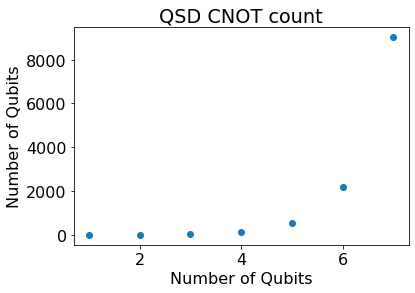

In [1367]:
plot_results(range(1, num), cxs, plot_name = "QSD CNOT count", x_axis_name = 'Number of Qubits', y_axis_name = 'Number of Qubits')

In [1354]:
qc.draw()

global phase: 5.5388
          ┌─────────────┐ ┌───────────────┐ ┌─────────────┐       ┌─────────┐  »
q99083_0: ┤ U1(-2.6448) ├─┤ R(2.0693,π/2) ├─┤ U1(0.94101) ├──■────┤ U1(π/2) ├──»
          ├─────────────┴┐├───────────────┴┐├─────────────┤┌─┴─┐┌─┴─────────┴─┐»
q99083_1: ┤ U1(-0.76483) ├┤ R(0.99689,π/2) ├┤ U1(-2.0872) ├┤ X ├┤ U1(-3.1367) ├»
          ├──────────────┤└────────────────┘└─────────────┘└───┘└─────────────┘»
q99083_2: ┤ Rz(-0.72761) ├─────────────────────────────────────────────────────»
          ├─────────────┬┘                                                     »
q99083_3: ┤ Rz(0.42881) ├──────────────────────────────────────────────────────»
          ├─────────────┴┐                                                     »
q99083_4: ┤ Rz(-0.27049) ├─────────────────────────────────────────────────────»
          ├──────────────┤                                                     »
q99083_5: ┤ Rz(-0.10043) ├─────────────────────────────────────────────────────»
          └──────────────┘                                                     »
«          ┌────────────────┐  ┌──────────┐      ┌──────────┐»
«q99083_0: ┤ R(0.93908,π/2) ├──┤ U1(-π/2) ├───■──┤ U1(-π/2) ├»
«          ├────────────────┤┌─┴──────────┴┐┌─┴─┐└┬────────┬┘»
«q99083_1: ┤ R(0.26161,π/2) ├┤ U1(-1.5759) ├┤ X ├─┤ U1(-π) ├─»
«          └────────────────┘└─────────────┘└───┘ └────────┘ »
«q99083_2: ──────────────────────────────────────────────────»
«                                                            »
«q99083_3: ──────────────────────────────────────────────────»
«                                                            »
«q99083_4: ──────────────────────────────────────────────────»
«                                                            »
«q99083_5: ──────────────────────────────────────────────────»
«                                                            »
«          ┌─────────────────┐                   ┌─────────────┐»
«q99083_0: ┤ R(-0.51069,π/2) ├────────────────■──┤ U1(-2.9727) ├»
«          └┬───────────────┬┘┌────────────┐┌─┴─┐└┬────────────┤»
«q99083_1: ─┤ R(1.5695,π/2) ├─┤ U1(1.5695) ├┤ X ├─┤ U1(2.7947) ├»
«           └───────────────┘ └────────────┘└───┘ └────────────┘»
«q99083_2: ─────────────────────────────────────────────────────»
«                                                               »
«q99083_3: ─────────────────────────────────────────────────────»
«                                                               »
«q99083_4: ─────────────────────────────────────────────────────»
«                                                               »
«q99083_5: ─────────────────────────────────────────────────────»
«                                                               »
«          ┌───────────────┐ ┌────────────┐                         »
«q99083_0: ┤ R(2.5442,π/2) ├─┤ U1(2.6956) ├──■──────────────────────»
«          ├───────────────┤┌┴────────────┤  │                      »
«q99083_1: ┤ R(2.3281,π/2) ├┤ U1(-2.8868) ├──┼───────────────────■──»
«          └───────────────┘└─────────────┘┌─┴─┐┌─────────────┐┌─┴─┐»
«q99083_2: ────────────────────────────────┤ X ├┤ Rz(-1.1775) ├┤ X ├»
«                                          └───┘└─────────────┘└───┘»
«q99083_3: ─────────────────────────────────────────────────────────»
«                                                                   »
«q99083_4: ─────────────────────────────────────────────────────────»
«                                                                   »
«q99083_5: ─────────────────────────────────────────────────────────»
«                                                                   »
«                               ┌─────────────┐ ┌───────────────┐»
«q99083_0: ──────────────────■──┤ U1(0.83478) ├─┤ R(1.6351,π/2) ├»
«                            │  └─────────────┘ └───────────────┘»
«q99083_1: ──────────────────┼──────────────────────────■────────»
«          ┌──────────────┐┌─┴─┐┌──────────────┐      ┌─┴─┐      »
«q99

In [1352]:
np.max(np.abs(Operator(gen_qsd(x)).data @ linalg.inv(x)) - np.identity((dim)))

8.442768761988841e-14

In [1344]:
qc.count_ops()

OrderedDict([('u1', 60), ('r', 32), ('cx', 24), ('rz', 8), ('ry', 4)])

In [1213]:
transpile(qc, optimization_level = 3).decompose().count_ops()

OrderedDict([('u3', 67), ('cx', 24), ('u1', 8), ('r', 4)])

In [651]:
qr, qc = basic_trotter_circuit(basic_trotter, 20, num_qubits = 3, target_time = np.pi/3, backend = jakarta, compiler = False)
transpile(qc, optimization_level = 3).decompose().count_ops()

OrderedDict([('cx', 240), ('ry', 160), ('rx', 160), ('rz', 120)])

In [652]:
unitary = Operator(qc).data

In [655]:
qsdqc = gen_qsd(unitary).decompose()

In [656]:
qsdqc.count_ops()

OrderedDict([('sdg', 160), ('u1', 120), ('h', 80), ('cx', 41), ('u3', 4)])

In [657]:
nqc = transpile(qsdqc, optimization_level = 3, backend = jakarta)

In [659]:
nqc.count_ops()

OrderedDict([('rz', 119), ('sx', 84), ('cx', 36), ('x', 3)])

# Classical Simulation 

In [31]:
def prepare_state(t):
    if t == np.pi:
        return (One^One^Zero)
    # Define initial state |110>
    initial_state = One^One^Zero
    return (U_heis3(float(t)) @ initial_state).eval()

In [32]:
prepare_state(np.pi/4).to_matrix()

array([ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        , -0.66666667-0.33333333j,
        0.        +0.j        ,  0.33333333-0.33333333j,
        0.33333333-0.33333333j,  0.        +0.j        ])

In [33]:
One^One^Zero

DictStateFn({'110': 1}, coeff=1.0, is_measurement=False)

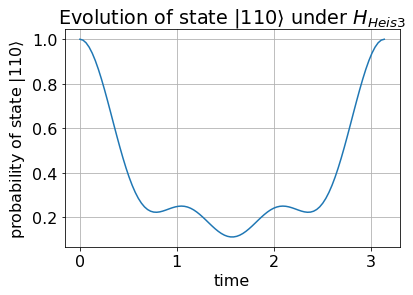

In [492]:
#IBM code

# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

# Circuits

In [500]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')
num_qubits = 3

In [501]:
def swap_gate():
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    qc.cx(qr[0], qr[1])
    qc.cx(qr[1], qr[0])
    qc.cx(qr[0], qr[1])
    return qc.to_instruction()

In [1490]:
def long_range_cx(target, controle, num_qubits):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    if np.abs(controle - target) == 1:
        qc.cx(controle, target)
        return qc
    
    if controle < target:
        
        for i in range(controle, target):
            qc.cx(i, i + 1)
        for i in range(target - 2, controle, -1):
            qc.cx(i, i + 1)
        for i in range(controle, target):
            qc.cx(i, i + 1)
        for i in range(target - 2, controle, -1):
            qc.cx(i, i + 1)
            
    if controle > target:
        
        for i in range(controle, target, -1):
            qc.cx(i, i - 1)
        for i in range(target + 2, controle):
            qc.cx(i, i - 1)
        for i in range(controle, target, -1):
            qc.cx(i, i - 1)
        for i in range(target + 2, controle):
            qc.cx(i, i - 1)
            
    return qc.to_instruction()
        

In [1489]:
long_range_cx(3, 0, 5).draw()

q140797_0: ──■───────────────────■─────────────────
           ┌─┴─┐               ┌─┴─┐               
q140797_1: ┤ X ├──■─────────■──┤ X ├──■─────────■──
           └───┘┌─┴─┐     ┌─┴─┐└───┘┌─┴─┐     ┌─┴─┐
q140797_2: ─────┤ X ├──■──┤ X ├─────┤ X ├──■──┤ X ├
                └───┘┌─┴─┐└───┘     └───┘┌─┴─┐└───┘
q140797_3: ──────────┤ X ├───────────────┤ X ├─────
                     └───┘               └───┘     
q140797_4: ────────────────────────────────────────

In [502]:
def QQ_gate(pauli_name, time = t, name = None):
    """
    Function returns a circuit instruction for \exp[i Q \otimes Q t], for a given Pauli operator Q
    Inputs: pauli_name, string, \in 'x', 'y', 'z'
            time, float
            name, string, labels gate
    Returns: QuantumCircuit instructions
    """
    
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr, name= name)
    
    if pauli_name == 'x':
        qc.ry(np.pi/2,[0,1])
    elif pauli_name =='y':
        qc.rx(np.pi/2,[0,1])
    
    qc.cnot(0,1)
    qc.rz(2 * time, 1)
    qc.cnot(0,1)
    
    if pauli_name == 'x':
        qc.ry(- np.pi/2,[0,1])
    elif pauli_name == 'y':
        qc.rx(- np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    return qc.to_instruction()

In [1927]:
def basic_trotter(terms = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2'], time = t, num_qubits = 3, backend = sim, compiler = False):
    """ 
    Constructs basic trotter decomposition for \exp[i H_heis t]
    Inputs: terms, list of strings, indicating gate sequence
            time, float
    Returns: QuantumCircuit instructions
    expected number of cxs is 12
    """
    
    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
    

    for index in terms:
        j, i = index[0], int(index[1]) - 1
        Trot_qc.append(QQ_gate(j, time = time), [Trot_qr[i], Trot_qr[i+1]])
        
    if compiler:
        Trot_qc = transpile(Trot_qc, basis_gates = backend.configuration().basis_gates, optimization_level = 3)
        
    # Convert custom quantum circuit into a gate
    Trot_gate = Trot_qc.to_instruction()
    return Trot_qc

In [1959]:
qc = basic_trotter(time = np.pi/4,terms = ['x1', 'y1', 'z1'], compiler = True).decompose()
qc.draw()

global phase: 7π/4
           ┌────────────┐                     ┌────────────────┐     »
q162091_0: ┤ R(π/2,π/2) ├──■───────────────■──┤ U3(π/2,-π,π/2) ├──■──»
           ├────────────┤┌─┴─┐┌─────────┐┌─┴─┐├────────────────┤┌─┴─┐»
q162091_1: ┤ R(π/2,π/2) ├┤ X ├┤ U1(π/2) ├┤ X ├┤ U3(π/2,-π,π/2) ├┤ X ├»
           └────────────┘└───┘└─────────┘└───┘└────────────────┘└───┘»
q162091_2: ──────────────────────────────────────────────────────────»
                                                                     »
«                           ┌───────────┐                     
«q162091_0: ─────────────■──┤ R(-π/2,0) ├──■───────────────■──
«           ┌─────────┐┌─┴─┐├───────────┤┌─┴─┐┌─────────┐┌─┴─┐
«q162091_1: ┤ U1(π/2) ├┤ X ├┤ R(-π/2,0) ├┤ X ├┤ U1(π/2) ├┤ X ├
«           └─────────┘└───┘└───────────┘└───┘└─────────┘└───┘
«q162091_2: ──────────────────────────────────────────────────
«

In [1960]:
nqc = gen_qsd(Operator(qc).data).decompose()

In [1961]:
nqc.draw()

global phase: 5.7609
           ┌─────────────────┐ ┌────────────────┐ ┌──────────────┐     »
q162119_0: ┤ U3(0,0,-1.1241) ├─┤ U3(3.0988,0,0) ├─┤ U3(0,0,-π/2) ├──■──»
           ├─────────────────┤┌┴────────────────┴┐├─────────────┬┘┌─┴─┐»
q162119_1: ┤ U3(0,0,-2.6949) ├┤ U3(0.088454,0,0) ├┤ U3(0,0,π/2) ├─┤ X ├»
           └────┬───────┬────┘└──────────────────┘└─────────────┘ └───┘»
q162119_2: ─────┤ U1(0) ├──────────────────────────────────────────────»
                └───────┘                                              »
«             ┌─────────────┐    ┌─────────────┐     ┌──────────────┐      »
«q162119_0: ──┤ U3(0,0,π/2) ├────┤ U3(π/4,0,0) ├─────┤ U3(0,0,-π/2) ├───■──»
«           ┌─┴─────────────┴─┐┌─┴─────────────┴──┐┌─┴──────────────┴┐┌─┴─┐»
«q162119_1: ┤ U3(0,0,-3.1117) ├┤ U3(0.044305,0,0) ├┤ U3(0,0,-1.6007) ├┤ X ├»
«           └─────────────────┘└──────────────────┘└─────────────────┘└───┘»
«q162119_2: ───────────────────────────────────────────────────────────────»
«                                                                          »
«           ┌──────────────┐┌────────────────┐                       »
«q162119_0: ┤ U3(0,0,-π/2) ├┤ U3(0.0895,0,0) ├────────────────────■──»
«           └┬────────────┬┘├────────────────┤┌────────────────┐┌─┴─┐»
«q162119_1: ─┤ U3(0,0,-π) ├─┤ U3(1.5695,0,0) ├┤ U3(0,0,1.5695) ├┤ X ├»
«            └────────────┘ └────────────────┘└────────────────┘└───┘»
«q162119_2: ─────────────────────────────────────────────────────────»
«                                                                    »
«             ┌─────────────┐  ┌────────────────┐┌─────────────────┐     »
«q162119_0: ──┤ U3(0,0,π/2) ├──┤ U3(2.3593,0,0) ├┤ U3(0,0,0.35558) ├──■──»
«           ┌─┴─────────────┴─┐├────────────────┤└┬────────────────┤  │  »
«q162119_1: ┤ U3(0,0,-1.5098) ├┤ U3(1.6987,0,0) ├─┤ U3(0,0,-1.404) ├──┼──»
«           └─────────────────┘└────────────────┘ └────────────────┘┌─┴─┐»
«q162119_2: ────────────────────────────────────────────────────────┤ X ├»
«                                                                   └───┘»
«                                            ┌────────────────┐»
«q162119_0: ──────────────────────────────■──┤ U3(0,0,1.2152) ├»
«                                         │  └────────────────┘»
«q162119_1: ─────────────■────────────────┼────────────────────»
«           ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐   ┌──────────┐   »
«q162119_2: ┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├───┤ U1(-π/4) ├───»
«           └─────────┘└───┘└──────────┘└───┘   └──────────┘   »
«           ┌────────────────┐  ┌─────────────┐                    »
«q162119_0: ┤ U3(2.3601,0,0) ├──┤ U3(0,0,π/2) ├────────────────────»
«           └────────────────┘┌─┴─────────────┴─┐┌────────────────┐»
«q162119_1: ────────■─────────┤ U3(0,0,-2.5234) ├┤ U3(1.6172,0,0) ├»
«                 ┌─┴─┐       └───┬──────────┬──┘└────────────────┘»
«q162119_2: ──────┤ X ├───────────┤ R(0,π/2) ├─────────────────────»
«                 └───┘           └──────────┘                     »
«                                    ┌─────────────┐    ┌─────────────┐   »
«q162119_0: ────────────────────■────┤ U3(0,0,π/2) ├────┤ U3(π/4,0,0) ├───»
«           ┌────────────────┐┌─┴─┐┌─┴─────────────┴─┐┌─┴─────────────┴──┐»
«q162119_1: ┤ U3(0,0,3.0089) ├┤ X ├┤ U3(0,0,-3.1031) ├┤ U3(0.034395,0,0) ├»
«           └────────────────┘└───┘└─────────────────┘└──────────────────┘»
«q162119_2: ──────────────────────────────────────────────────────────────»
«                                                                         »
«             ┌──────────────┐      ┌──────────────┐┌──────────────────┐»
«q162119_0: ──┤ U3(0,0,-π/2) ├───■──┤ U3(0,0,-π/2) ├┤ U3(0.093578,0,0) ├»
«           ┌─┴──────────────┴┐┌─┴─┐└┬────────────┬┘└┬────────────────┬┘»
«q162119_1: ┤ U3(0,0,-1.6093) ├┤ X ├─┤ U3(0,0,-π) ├──┤ U3(1.5695,0,0) ├─»
«           └─────────────────┘└───┘ └────────────┘  └────────────────┘ »
«q162119_2: ───────────────────────────────────────────────────────

In [1981]:
qc = basic_trotter(time = np.pi/3, terms = ['x1', 'y1', 'z1'], num_qubits =2, compiler = True)


qc.count_ops()

OrderedDict([('cx', 6), ('rz', 3), ('ry', 2), ('u2', 2), ('rx', 2)])

In [1982]:
nqc = gen_qsd(Operator(qc).data).decompose()
nqc.count_ops()

OrderedDict([('u3', 19), ('cx', 3)])

In [1930]:
def ti_trotter(terms = None, time=t, backend = sim, compiler = False):
    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')
    
    ti_terms = ['x1', 'y1', 'z1']
    ti_evolution = basic_trotter(ti_terms, time, num_qubits = 2, backend=backend, compiler = compiler)
    Trot_qc.append(ti_evolution, [Trot_qr[0], Trot_qr[1]])
    Trot_qc.append(ti_evolution, [Trot_qr[1], Trot_qr[2]])
    
    if compiler:
        Trot_qc = transpile(Trot_qc, basis_gates = backend.configuration().basis_gates, optimization_level=3)

    # Convert custom quantum circuit into a gate
    Trot_gate = Trot_qc.decompose()
    Trot_gate = Trot_qc.to_instruction()
    return Trot_qc

In [1188]:
time_steps = 10
ts = [ i*np.pi/time_steps for i in range(1, time_steps+1)] 
cxs = []
for t in ts:    
    Trot_qr = QuantumRegister(3)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot') 
    qr, qc = basic_trotter_circuit(ti_trotter, 8, target_time = t, num_qubits = 3, backend = sim_noisy_jakarta, compiler = True)
    Trot_qc.append(qc, [Trot_qr[0], Trot_qr[1], Trot_qr[2]])
    ncx = Trot_qc.decompose().count_ops().get('cx',0)
    cxs.append(ncx)


In [1699]:
def basic_trotter_circuit(trotter_gate_function, trotter_steps, num_qubits = 7, target_time = np.pi, terms = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2'], operational_qubits = [0, 1, 2], backend = sim, compiler = False):
    """ 
    Constructs Trotter Circuit for Jakarta machine by Repeating a given gate
    Inputs: trotter_gate_function, function, returns QuantumCircuit instructions 
            trotter_steps, int
            target_time, final simulation time, assumed = np.pi
            terms, list of strings, indicating gate sequence
    
    Returns: QuantumRegister, QuantumCircuit 
    """
    q1, q2, q3 = operational_qubits
        
    # Initialize quantum circuit for n qubits
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(trotter_gate_function(terms = terms,time=target_time/trotter_steps, backend = backend, compiler = compiler), [qr[q1], qr[q2], qr[q3]])
        
    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.decompose()
    if compiler:
        qc = transpile(qc, optimization_level = 3, basis_gates  = backend.configuration().basis_gates)
    
    #qc = qc.bind_parameters({t: target_time/trotter_steps})
    

    return qr, qc 

In [1701]:
def ti_higher_order_trotter(order = 2, time = t, random = False, terms = None):
    def wrapper(terms = terms, time = time, backend = sim, compiler = False):
        
        num_qubits = 3
        Trot_qr = QuantumRegister(num_qubits)
        Trot_qc = QuantumCircuit(Trot_qr, name='Higher_Order_Trot')
        ti_terms = ['x1', 'y1', 'z1']

        coefficients = higher_trotter_coefficients(['1','2'], order, time)

        for term, coefficient in coefficients:
            i = int(term) - 1
            ti_evolution = basic_trotter(ti_terms, time = coefficient, num_qubits = 2)
            Trot_qc.append(ti_evolution, [Trot_qr[i], Trot_qr[i+1]])
            
        if compiler:
            Trot_qc = transpile(Trot_qc, basis_gates = backend.configuration().basis_gates, optimization_level=3)

        # Convert custom quantum circuit into a gate
        Trot_gate = Trot_qc.to_instruction()
        return Trot_gate
    
    return wrapper


In [1702]:
def higher_order_trotter(order = 2, time = t, random = False, terms = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2']):
    '''
    Generates higher order trotter gate function.
    Inputs: order, int, order of higher order formula
            time, float, time of simulation of this trotter step
            random, boolean, random choice of term ordering?
            terms, list of strings, indicating order of decomposition
    Returns: Function, which returns QuantumCircuit instructions
    '''
    
    def wrapper(terms = terms, time = time,  backend = sim, compiler = False):

        num_qubits = 3
        Trot_qr = QuantumRegister(num_qubits)
        Trot_qc = QuantumCircuit(Trot_qr, name='TI Higher_Order_Trot')

        if random:
            terms = np.random.permutation(['x1', 'y1', 'z1', 'x2', 'y2', 'z2'])

        coefficients = higher_trotter_coefficients(terms, order, time)

        for term, coefficient in coefficients:
            j, i = term[0], int(term[1]) - 1
            Trot_qc.append(QQ_gate(j, coefficient), [Trot_qr[i], Trot_qr[i+1]])
            
        if compiler:
            Trot_qc = transpile(Trot_qc, basis_gates = backend.configuration().basis_gates, optimization_level=3)

        # Convert custom quantum circuit into a gate
        Trot_gate = Trot_qc.to_instruction()
        return Trot_gate
    
    
    return wrapper


In [1703]:
def higher_trotter_coefficients(terms, order, time):
    """ 
    Recursively computes the order and the exponents of the higher order trotter decomposition
    Implementation based on the paper The Theory of Trotter Error [need citation]
    Inputs: terms, list of strings, indicating gate sequence
            order, int, order of formula
            time, float
    Returns: list of tuples, (string, float)
    """
    
    coefficients = []
    
    if order == 1:
        for term in terms:
            coefficients.append((term, time))
        return coefficients
        
    if order == 2:
        for term in terms[:-1]:
            coefficients.append((term, time/2))
        
        coefficients.append((terms[-1], time))
        
        for term in reversed(terms[:-1]):
            coefficients.append((term, time/2))
            
        return coefficients
    
    u_order = 1/(4 - 4**(1/(order-1)))
    
    previous = higher_trotter_coefficients(terms, order - 2, u_order*time)
    middle = higher_trotter_coefficients(terms, order - 2, (1 - 4*u_order)*time)
    
    coefficients = previous + previous + middle + previous + previous
    
    return hot_parse_coefficients(coefficients)
    

In [1704]:
def hot_parse_coefficients(coefficients):
    
    new_c = []
    current_term, current_coefficient = coefficients[0] 
     
    for term, coef in coefficients[1:]:
        if term != current_term:
            new_c.append([current_term, current_coefficient])
            current_term = term
            current_coefficient = coef
        else:
            current_coefficient += coef
            
    new_c.append([current_term, current_coefficient])
    return new_c
    
        

In [1944]:
def qsd_qc(t, backend = sim, coupling_map = None):
    
    time_evol = U_heis3(t).to_matrix()
    circuit = gen_qsd(time_evol, coupling_map = coupling_map ).decompose()
    #circuit = transpile(circuit, basis_gates = backend.configuration().basis_gates, optimization_level = 3)
    
    return circuit.decompose()

In [2]:
qsd_qc(np.pi, sim_noisy_jakarta, coupling_map = None ).count_ops()

NameError: name 'qsd_qc' is not defined

In [1949]:
qsd_qc(np.pi/20, sim_noisy_jakarta, coupling_map = line(3) ).count_ops()

TypeError: 'list' object is not callable

In [1851]:
qc = qsd_qc(np.pi/20, jakarta, coupling_map = line(3))
qc.draw()

global phase: 2.4117
           ┌─────────────┐               ┌───┐┌──────────────┐           »
q156095_0: ┤ U1(-2.3807) ├───────────────┤ X ├┤ U1(-0.75024) ├───────────»
           └┬───────────┬┘┌─────────────┐└─┬─┘└───┬─────┬────┘   ┌───┐   »
q156095_1: ─┤ U3(π,0,π) ├─┤ U1(-2.5033) ├──■──────┤ Sdg ├────────┤ H ├───»
           ┌┴───────────┴┐└───┬─────┬───┘┌───┐    ├─────┤     ┌──┴───┴──┐»
q156095_2: ┤ U1(-3.1403) ├────┤ Sdg ├────┤ H ├────┤ Sdg ├─────┤ U1(π/2) ├»
           └─────────────┘    └─────┘    └───┘    └─────┘     └─────────┘»
«                                 ┌───┐┌────────────┐            ┌───┐»
«q156095_0: ──────────────────────┤ X ├┤ U1(0.1508) ├────────────┤ X ├»
«           ┌─────┐┌─────────────┐└─┬─┘└──┬─────┬───┘┌───┐┌─────┐└─┬─┘»
«q156095_1: ┤ Sdg ├┤ U1(-2.9732) ├──■─────┤ Sdg ├────┤ H ├┤ Sdg ├──■──»
«           └─────┘└─────────────┘        └─────┘    └───┘└─────┘     »
«q156095_2: ──────────────────────────────────────────────────────────»
«                                                                     »
«             ┌─────┐   ┌───┐ ┌─────┐┌──────────────┐    ┌─────┐     ┌───┐ »
«q156095_0: ──┤ Sdg ├───┤ H ├─┤ Sdg ├┤ U1(0.028608) ├────┤ Sdg ├─────┤ H ├─»
«           ┌─┴─────┴─┐┌┴───┴┐└┬───┬┘└───┬─────┬────┘┌───┴─────┴───┐┌┴───┴┐»
«q156095_1: ┤ U1(π/2) ├┤ Sdg ├─┤ H ├─────┤ Sdg ├─────┤ U1(-1.5965) ├┤ Sdg ├»
«           └─────────┘└─────┘ └───┘     └─────┘     └─────────────┘└─────┘»
«q156095_2: ───────────────────────────────────────────────────────────────»
«                                                                          »
«           ┌─────┐┌─────────┐                                             »
«q156095_0: ┤ Sdg ├┤ U1(π/2) ├─────────────────────────────────────────────»
«           └┬───┬┘└─┬─────┬─┘┌─────────────┐     ┌───────────┐┌──────────┐»
«q156095_1: ─┤ H ├───┤ Sdg ├──┤ U1(0.84308) ├──■──┤ U3(π,0,π) ├┤ U1(-π/2) ├»
«            └───┘   └─────┘  └─────────────┘┌─┴─┐└┬─────────┬┘└─┬─────┬──┘»
«q156095_2: ─────────────────────────────────┤ X ├─┤ U1(π/2) ├───┤ Sdg ├───»
«                                            └───┘ └─────────┘   └─────┘   »
«                ┌─────┐    ┌───┐     ┌─────┐┌─────────────┐┌─────┐»
«q156095_0: ──■──┤ Sdg ├────┤ H ├─────┤ Sdg ├┤ U1(-1.5708) ├┤ Sdg ├»
«           ┌─┴─┐└─────┘    └───┘     └─────┘└─────────────┘└─────┘»
«q156095_1: ┤ X ├────────────────────────■─────────────────────■───»
«           ├───┤┌─────┐┌────────────┐ ┌─┴─┐ ┌─────────────┐ ┌─┴─┐ »
«q156095_2: ┤ H ├┤ Sdg ├┤ U1(2.4976) ├─┤ X ├─┤ U1(0.58921) ├─┤ X ├─»
«           └───┘└─────┘└────────────┘ └───┘ └─────────────┘ └───┘ »
«                ┌───┐     ┌─────┐┌─────────┐                                 »
«q156095_0: ─────┤ H ├─────┤ Sdg ├┤ U1(π/2) ├─────────────────────────────────»
«           ┌────┴───┴────┐├─────┤└──┬───┬──┘┌─────┐┌────────────┐┌─────┐┌───┐»
«q156095_1: ┤ U1(0.58689) ├┤ Sdg ├───┤ H ├───┤ Sdg ├┤ U1(1.5769) ├┤ Sdg ├┤ H ├»
«           └──┬────────┬─┘├─────┤   ├───┤   ├─────┤├────────────┤├─────┤├───┤»
«q156095_2: ───┤ U1(-π) ├──┤ Sdg ├───┤ H ├───┤ Sdg ├┤ U1(2.8301) ├┤ Sdg ├┤ H ├»
«              └────────┘  └─────┘   └───┘   └─────┘└────────────┘└─────┘└───┘»
«                          ┌─────┐    ┌───┐┌─────┐┌──────────────┐┌─────┐┌───┐»
«q156095_0: ─────────■─────┤ Sdg ├────┤ H ├┤ Sdg ├┤ U1(-0.84307) ├┤ Sdg ├┤ H ├»
«           ┌─────┐┌─┴─┐┌──┴─────┴───┐└───┘└─────┘└──────────────┘└─────┘└───┘»
«q156095_1: ┤ Sdg ├┤ X ├┤ U1(1.5647) ├────────────────────────────────────────»
«           ├─────┤└───┘└────────────┘                                        »
«q156095_2: ┤ Sdg ├───────────────────────────────────────────────────────────»
«           └─────┘                                                           »
«           ┌─────┐      ┌─────────┐  ┌─────┐┌───┐┌─────┐┌─────────────┐┌─────┐»
«q156095_0: ┤ Sdg ├──■───┤ U1(π/2) ├──┤ Sdg ├┤ H ├┤ Sdg ├┤ U1(-1.5662) ├┤ Sdg ├»
«           └─────┘┌─┴─┐┌┴─────────┴─┐├─────┤├───┤├─────┤├─────────────┤├─────┤»
«q156095_1: ───────┤ X ├┤ 

In [1852]:
jbasis

['id', 'rz', 'sx', 'x', 'cx', 'reset']

# Evaluation and Tomography

In [1768]:
def evaluate_circuit( st_qcs, backend = sim, shots = 5000, reps = 8, verbose = False):
    """
    Repeated evaluation and tomography of quantum circuit
    Inputs: st_qcs, state tomography circuit
            backend, 
            shots, number of repetitions for state tomography
            reps, number of overall evaluations
    """

    jobs = []
    for _ in range(reps):
        # execute
        #if noise_model:
        #    job = execute(st_qcs, backend, shots=shots, noise_model = noise_model)
        #else:
        job = execute(st_qcs, backend, shots=shots)
        if verbose:
            print('Job ID', job.job_id())
        jobs.append(job)
        
    return jobs

In [1706]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those circuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [1707]:
def tomography(result, st_qcs, target_state):
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state.to_matrix())
    return fid

In [1708]:
def average_fidelity(jobs, st_qcs, result_state,  verbose = True):
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        
        # uncomment here for submission
        #fid = state_tomo(job.result(), st_qcs)
        fid = tomography(job.result(), st_qcs,  result_state)
        fids.append(fid)

    if verbose:
        print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    
    return np.mean(fids)

In [1709]:
def gen_testing_circuit(trotter_function, trotter_steps, num_qubits = 7, target_time = np.pi,  terms = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2'],  backend = sim, operational_qubits = [1, 3, 5], compiler = False, pauli_compiler = False, coupling_map = None, shuttle = False, qsd = False):
    q1, q2, q3 = operational_qubits
    
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
        
    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([operational_qubits[1], operational_qubits[2]])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    
    # generate circuit, compile, parse to instructions
    qr2, time_ev_circ = basic_trotter_circuit(trotter_function, trotter_steps, terms = terms, target_time = target_time, num_qubits = len(operational_qubits), compiler = compiler )
    
    
    if pauli_compiler:
        time_ev_circ = pauli_transpilation(time_ev_circ, 3, backend = backend, coupling_map = coupling_map)
        
    if qsd:
        qsd_circ = gen_qsd(Operator(time_ev_circ).data)
        time_ev_circ = transpile(qsd_circ, optimization_level = 3, backend = backend)
        
    circuit_instructions = time_ev_circ.to_instruction()
    
    if shuttle:
        q1, q2, q3 = 3, 5, 6
        qc.x([qr[3], qr[6]])
        qc.append(circuit_instructions, [qr[q1], qr[q2], qr[q3]])
        qc.append(swap_gate(), [qr[1], qr[3]])
        qc.append(swap_gate(), [qr[3], qr[5]])
        qc.append(swap_gate(), [qr[5], qr[6]])
    else:
        qc.append(circuit_instructions, [qr[q1], qr[q2], qr[q3]])
        
    print("Circuit Description ", qc.decompose().count_ops())
    
    return qr, qc

In [1710]:
def test_circuit(trotter_function, trotter_steps, target_time = np.pi, num_qubits = 7, repetitions = 5, backend_name = None, backend = sim, terms = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2'], noise_model = None, compiler = False, pauli_compiler =  False, coupling_map = None, active_qubits = 3, shuttle = False, qsd = False):
    """
    Runs trotterized circuit and returns average fidelity
    Inputs: trotter_function, function which returns QC instructions for trotter gate
            trotter_steps, int, number of trotter repetitions
            repetitions, int, number of experiments averaged over
            backend
            terms, list of strings, indicating order of decomposition
    """
    
    # need to fix thiss.....
    if num_qubits <= 3 or backend_name == 'quito':
        q1, q2, q3 = 0, 1, 2
    elif (not backend_name) or backend_name == 'jakarta':
        q1, q2, q3 = 1, 3, 5
        
    operational_qubits = [q1, q2, q3]
        
    # generate circuit, compile, parse to instructions
    qr, qc = gen_testing_circuit(trotter_function, trotter_steps, target_time = target_time, num_qubits = num_qubits, terms = terms, operational_qubits = operational_qubits, compiler = compiler,  coupling_map = coupling_map, shuttle=shuttle, pauli_compiler = pauli_compiler, qsd = qsd )
    
    # tomography circuit
    st_qcs  =  state_tomography_circuits(qc, [qr[q1], qr[q2], qr[q3]])
        
    # assign jobs and evaluate
    jobs = evaluate_circuit(st_qcs, reps = repetitions, backend = backend)
    
    result_state = prepare_state(target_time)
    fid = average_fidelity(jobs, st_qcs, result_state)
    
    return fid

In [1897]:
def test(instructions, target_time = np.pi, num_qubits = 7, backend = sim, shuttle = False, verbose = False):
    repetitions = 3
    
    
    # need to fix thiss.....
    if num_qubits <= 3:
        q1, q2, q3 = 0, 1, 2
    elif num_qubits >= 6:
        q1, q2, q3 = 1, 3, 5
    
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    
    if shuttle:
        qc.x([qr[5], qr[6]])
        qc.append(instructions, [qr[3], qr[5], qr[6]])
        qc.append(swap_gate(), [qr[1], qr[3]])
        qc.append(swap_gate(), [qr[3], qr[5]])
        qc.append(swap_gate(), [qr[5], qr[6]])
    else:
        qc.x([qr[q2], qr[q3]])
        qc.append(instructions, [qr[q1], qr[q2], qr[q3]])
    
    if verbose:
        print(qc.decompose().count_ops())
        print(qc.decompose().draw())
    
    qc2 =  QuantumCircuit(qr)
    qc2.append(transpile(qc, backend), qr)
        
    if verbose:
        print(qc2.decompose().count_ops())
        print(qc2.decompose().draw())
        
    # tomography circuit
    st_qcs  =  state_tomography_circuits(qc2, [qr[q1], qr[q2], qr[q3]])
        
    # assign jobs and evaluate
    jobs = evaluate_circuit(st_qcs, reps = repetitions, backend = backend, verbose = verbose)
    
    result_state = prepare_state(target_time)
    fid = average_fidelity(jobs, st_qcs, result_state)
    return fid
    

In [1898]:
np.round(U_heis3(np.pi).to_matrix())

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  1.-0.j,  0.+0.j,  0.+0.j, -0.-0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j, -0.+0.j,  1.-0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j, -0.+0.j, -0.+0.j,
         0.+0.j],
       [ 0.+0.j, -0.-0.j, -0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  1.-0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         1.+0.j]])

In [1902]:
time = np.pi
instr = qsd_qc(time, coupling_map = line(3))
test(instr, target_time = time, backend = sim_noisy_jakarta, num_qubits = 7, verbose = True, shuttle = False)


OrderedDict([('cx', 31), ('u3', 26), ('u', 12), ('u1', 8)])
global phase: 2.8063
                                                                            »
q161160_0: ─────────────────────────────────────────────────────────────────»
           ┌───────────────────────────┐                                    »
q161160_1: ┤ U3(2.2735,-1.2708,0.2603) ├─────────────────────────────────■──»
           └───────────────────────────┘                                 │  »
q161160_2: ──────────────────────────────────────────────────────────────┼──»
                   ┌───────────┐        ┌─────────────────────────────┐┌─┴─┐»
q161160_3: ────────┤ U3(π,0,π) ├────────┤ U3(0.77383,-0.55268,-3.117) ├┤ X ├»
                   └───────────┘        └─────────────────────────────┘└───┘»
q161160_4: ─────────────────────────────────────────────────────────────────»
                   ┌───────────┐               ┌────────────────┐           »
q161160_5: ────────┤ U3(π,0,π) ├───────────────┤ U1(-0.001792

Job ID c0619bdd-c158-4632-b611-9dc6fd7d69a8
Job ID a235b701-676d-4422-be4b-ecadaf59544a
Job ID b25e92f6-81d0-497f-ba0b-0988a0141743
state tomography fidelity = 0.9957 ± 0.0008


0.9956952329773578

# Testing (Sistematically)

In [1711]:
def steps_experiment(trotter_function, n_max , n_min = 4, target_time = np.pi, step=1, repetitions = 3, backend_name=None, backend = sim, terms = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2'], noise_model = None, compiler = False, shuttle=False, pauli_compiler = False, qsd = False):
    """
    Repeatedly runs test_circuit to evaluate a given trotter decomposition as we increase the number of steps
    Inputs: trotter_function, function which returns QC instructions for trotter gate
            n_max, int, max number of trotter_steps
            n_min, int, min number of trotter_steps
            step, int, spacing between trotter_steps
            repetitions, int, number of experiments averaged over
            backend
            terms, list of strings, indicating order of decomposition
    
    """
    
    fids = []
    n_steps = []
    
    for i in range(n_min, n_max, step):
        n_steps.append(i)
        fids.append(test_circuit(trotter_function, i, target_time = target_time, repetitions = repetitions, backend_name = backend_name, backend = backend, noise_model = noise_model, compiler = compiler, pauli_compiler=pauli_compiler, shuttle=shuttle, qsd = qsd))
        
    return n_steps, fids        

In [1712]:
def time_experiment(trotter_function, trotter_steps , time_steps = 10, max_time = np.pi, step=1, repetitions = 3, backend_name=None, backend = sim, terms = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2'], noise_model = None, compiler = False, shuttle=False, pauli_compiler = False):
    
    ts = [ i * max_time/time_steps for i in range(1, time_steps + 1)]
    fids = []
    
    for t in ts:
        print("Simulating until time ", t)
        fids.append(test_circuit(trotter_function, trotter_steps, target_time = t, repetitions = repetitions, backend_name = backend_name, backend = backend, noise_model = noise_model, compiler = compiler, pauli_compiler=pauli_compiler, shuttle=shuttle))
        
    return ts, fids

In [1713]:
def plot_results(x, y, plot_name = None, x_axis_name = None, y_axis_name = "Average State Fidelity"):
    
    plt.scatter(x, y)
    
    if plot_name:
        plt.title(plot_name)
        
    if x_axis_name:
        plt.xlabel(x_axis_name)
    if y_axis_name:
        plt.ylabel(y_axis_name)
        
    plt.show()

# Direct Transpilation of Time Evolution

In [821]:
qr = QuantumRegister(3)
qc = QuantumCircuit( qr) 
qc.append(Operator(U_heis3(np.pi/3)), qr)
qc = transpile(qc, optimization_level = 3,  basis_gates = jbasis)

In [1114]:
def direct_transpilation(time = t, backend = sim, compiler = True, terms = None):
    qr = QuantumRegister(3)
    qc = QuantumCircuit( qr) 
    qc.append(Operator(U_heis3(time)), qr)
    qc = transpile(qc, optimization_level = 3,  basis_gates = jbasis)
    return qc
    #return qc.to_instruction()
    

In [1122]:
time = np.pi/2
qc = direct_transpilation(time, backend = sim_noisy_jakarta)
qc.count_ops()

OrderedDict([('rz', 104), ('sx', 69), ('cx', 37), ('x', 4)])

In [1119]:
qc.draw()

global phase: 3π/4
           ┌─────────────┐┌───┐┌──────────────┐┌───┐┌────────────┐┌───┐»
q111064_0: ┤ Rz(0.94466) ├┤ X ├┤ Rz(-0.39224) ├┤ X ├┤ Rz(1.8182) ├┤ X ├»
           └─────────────┘└─┬─┘└──────────────┘└─┬─┘└────────────┘└─┬─┘»
q111064_1: ─────────────────■────────────────────┼──────────────────■──»
                                                 │                     »
q111064_2: ──────────────────────────────────────■─────────────────────»
                                                                       »
«            ┌─────────┐  ┌───┐┌─────────────┐     ┌────┐    ┌─────────────┐»
«q111064_0: ─┤ Rz(1.1) ├──┤ X ├┤ Rz(-1.4417) ├─────┤ √X ├────┤ Rz(-2.2941) ├»
«           ┌┴─────────┴─┐└─┬─┘└────┬───┬────┘┌────┴────┴───┐└────┬───┬────┘»
«q111064_1: ┤ Rz(2.6618) ├──┼───────┤ X ├─────┤ Rz(0.51927) ├─────┤ X ├─────»
«           └────────────┘  │       └─┬─┘     └─────────────┘     └─┬─┘     »
«q111064_2: ────────────────■─────────■─────────────────────────────■───────»
«                                                                           »
«                ┌────┐    ┌────────────┐┌───┐┌────────────┐    ┌────┐    »
«q111064_0: ─────┤ √X ├────┤ Rz(2.8032) ├┤ X ├┤ Rz(2.2384) ├────┤ √X ├────»
«                └────┘    └────────────┘└─┬─┘└───┬───┬────┘┌───┴────┴───┐»
«q111064_1: ───────────────────────────────■──────┤ X ├─────┤ Rz(2.6961) ├»
«           ┌─────────────┐                       └───┘     └────────────┘»
«q111064_2: ┤ Rz(-2.3566) ├───────────────────────────────────────────────»
«           └─────────────┘                                               »
«           ┌─────────────┐┌────┐┌───────────┐┌───┐┌─────────┐┌────┐»
«q111064_0: ┤ Rz(-1.2198) ├┤ √X ├┤ Rz(2.353) ├┤ X ├┤ Rz(π/2) ├┤ √X ├»
«           └─────────────┘└────┘└───────────┘└─┬─┘└─────────┘└────┘»
«q111064_1: ────────────────────────────────────┼───────────────────»
«                                               │                   »
«q111064_2: ────────────────────────────────────■───────────────────»
«                                                                   »
«           ┌──────────────┐┌────┐┌─────────┐        ┌────┐  ┌──────────────┐»
«q111064_0: ┤ Rz(-0.96523) ├┤ √X ├┤ Rz(π/4) ├──■─────┤ √X ├──┤ Rz(-0.70844) ├»
«           └──────────────┘└────┘└─────────┘┌─┴─┐┌──┴────┴─┐└──────────────┘»
«q111064_1: ─────────────────────────────────┤ X ├┤ Rz(π/4) ├────────────────»
«                                            └───┘└─────────┘                »
«q111064_2: ─────────────────────────────────────────────────────────────────»
«                                                                            »
«           ┌────┐         ┌────┐    ┌─────────────┐                     »
«q111064_0: ┤ √X ├──■──────┤ √X ├────┤ Rz(-1.9394) ├─────────────────────»
«           └────┘┌─┴─┐┌───┴────┴───┐└────┬────┬───┘┌─────────────┐┌────┐»
«q111064_1: ──────┤ X ├┤ Rz(2.7938) ├─────┤ √X ├────┤ Rz(-1.8549) ├┤ √X ├»
«                 └───┘└────────────┘     └────┘    └─────────────┘└────┘»
«q111064_2: ─────────────────────────────────────────────────────────────»
«                                                                        »
«                                                                      »
«q111064_0: ───────────────────────────────────────────────────────────»
«           ┌────────────┐┌───┐┌──────────┐┌────┐┌──────────────┐┌────┐»
«q111064_1: ┤ Rz(2.4834) ├┤ X ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-0.44544) ├┤ √X ├»
«           └────────────┘└─┬─┘└──────────┘└────┘└──────────────┘└────┘»
«q111064_2: ────────────────■──────────────────────────────────────────»
«                                                                      »
«                                   ┌───┐          ┌────────────┐»
«q111064_0: ────────────────■───────┤ X ├───────■──┤ Rz(2.4133) ├»
«           ┌────────────┐┌─┴─┐┌────┴───┴────┐┌─┴─┐└───┬────┬───┘»
«q111064_1: ┤ Rz(2.4332) ├┤ X ├┤ Rz(0.70844) ├┤ X ├────┤ √X ├────»
«           └────────────┘└───┘└─────────────

In [851]:
nqc = transpile(qc, optimization_level = 3,  basis_gates = jbasis)

In [852]:
np.sum(np.abs(Operator(nqc).data - Operator(U_heis3(time)).data)**2)

27.31370849898478

In [837]:
nqc.count_ops()

OrderedDict([('rz', 105), ('sx', 71), ('cx', 37), ('x', 3)])

In [796]:
L = 10
cxs = []
for i in range(1, L):
    qr = QuantumRegister(3)
    qc = QuantumCircuit( qr) 
    qc.append(Operator(U_heis3(np.pi/i)), qr)
    qc = transpile(qc, basis_gates = jbasis, optimization_level = 3)
    cxs.append(i * qc.count_ops().get('cx', 0))
    

In [797]:
cxs

[0, 82, 87, 164, 205, 246, 287, 328, 369]

In [777]:
qc.draw()

global phase: 9π/8
          ┌─────────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐┌───┐»
q98423_0: ┤ Rz(0.75737) ├┤ X ├┤ Rz(-0.43852) ├┤ X ├┤ Rz(-2.5918) ├┤ X ├»
          └─────────────┘└─┬─┘└──────────────┘└─┬─┘└─────────────┘└─┬─┘»
q98423_1: ─────────────────■────────────────────┼───────────────────■──»
                                                │                      »
q98423_2: ──────────────────────────────────────■──────────────────────»
                                                                       »
«          ┌─────────────┐┌───┐┌─────────────┐     ┌────┐    ┌─────────────┐»
«q98423_0: ┤ Rz(-1.7099) ├┤ X ├┤ Rz(-1.4109) ├─────┤ √X ├────┤ Rz(-1.1135) ├»
«          ├─────────────┤└─┬─┘└────┬───┬────┘┌────┴────┴───┐└────┬───┬────┘»
«q98423_1: ┤ Rz(0.38372) ├──┼───────┤ X ├─────┤ Rz(0.36161) ├─────┤ X ├─────»
«          └─────────────┘  │       └─┬─┘     └─────────────┘     └─┬─┘     »
«q98423_2: ─────────────────■─────────■─────────────────────────────■───────»
«                                                                           »
«              ┌────┐    ┌─────────────┐┌───┐┌─────────────┐┌────┐»
«q98423_0: ────┤ √X ├────┤ Rz(-2.4785) ├┤ X ├┤ Rz(-1.0486) ├┤ √X ├»
«              └────┘    └─────────────┘└─┬─┘└─────────────┘└────┘»
«q98423_1: ───────────────────────────────■───────────────────────»
«          ┌────────────┐                                         »
«q98423_2: ┤ Rz(-1.279) ├─────────────────────────────────────────»
«          └────────────┘                                         »
«          ┌──────────────┐┌────┐┌──────────────┐┌───┐┌─────────────┐┌────┐»
«q98423_0: ┤ Rz(-0.48817) ├┤ √X ├┤ Rz(-0.34414) ├┤ X ├┤ Rz(0.83645) ├┤ √X ├»
«          └──────────────┘└────┘└──────────────┘└─┬─┘└─────────────┘└────┘»
«q98423_1: ────────────────────────────────────────┼───────────────────────»
«                                                  │                       »
«q98423_2: ────────────────────────────────────────■───────────────────────»
«                                                                          »
«          ┌─────────────┐┌────┐┌────────────┐┌───┐┌─────────────┐┌────┐»
«q98423_0: ┤ Rz(-1.6624) ├┤ √X ├┤ Rz(1.3337) ├┤ X ├┤ Rz(-2.8221) ├┤ √X ├»
«          └─────────────┘└────┘└────────────┘└─┬─┘├─────────────┤├────┤»
«q98423_1: ─────────────────────────────────────■──┤ Rz(-1.5693) ├┤ √X ├»
«                                                  └─────────────┘└────┘»
«q98423_2: ─────────────────────────────────────────────────────────────»
«                                                                       »
«          ┌──────────────┐┌────┐┌─────────────┐                         »
«q98423_0: ┤ Rz(-0.84023) ├┤ √X ├┤ Rz(-1.7849) ├──■──────────────────────»
«          ├─────────────┬┘├────┤└┬────────────┤┌─┴─┐┌────────────┐┌────┐»
«q98423_1: ┤ Rz(-1.9323) ├─┤ √X ├─┤ Rz(3.1332) ├┤ X ├┤ Rz(1.5786) ├┤ √X ├»
«          └─────────────┘ └────┘ └────────────┘└───┘└────────────┘└────┘»
«q98423_2: ──────────────────────────────────────────────────────────────»
«                                                                        »
«                                                                      »
«q98423_0: ────────────────────────────────────────────────────────────»
«          ┌─────────────┐┌────┐┌────────────┐┌───┐┌────────────┐┌────┐»
«q98423_1: ┤ Rz(-1.5722) ├┤ √X ├┤ Rz(1.9323) ├┤ X ├┤ Rz(1.2093) ├┤ √X ├»
«          └─────────────┘└────┘└────────────┘└─┬─┘└────────────┘└────┘»
«q98423_2: ─────────────────────────────────────■──────────────────────»
«                                                                      »
«                                                    ┌────────┐  ┌────┐»
«q98423_0: ─────────────────────────────────────■────┤ Rz(-π) ├──┤ √X ├»
«          ┌─────────────┐┌────┐┌────────────┐┌─┴─┐┌─┴────────┴─┐├────┤»
«q98423_1: ┤ Rz(-1.5694) ├┤ √X ├┤ Rz(1.5786) ├┤ X ├┤ Rz(3.1332) ├┤ √X ├»
«          └─────────────┘└────┘└────────────┘└───┘└───────────

# Transpilation Optimization

In [202]:
from qiskit.quantum_info import Operator

In [514]:
def pauli_transpilation(circuit, num_qubits, backend = sim, k = 1, coupling_map = None):

    # generate circuit matrix
    qc_matrix = Operator(circuit.decompose()).data
    
    # Pauli decomposition 
    qc_coeffs = matrix_decomposition(qc_matrix, num_qubits )
    qc_op = coef_to_operator(qc_coeffs,  num_qubits )
    
    # reconstruction to circuit
    qc_paulicircuit = QuantumCircuit(num_qubits)
    qc_paulicircuit.append(qc_op , range(num_qubits))
    
    if not coupling_map:
        coupling_map = [[i, i+1] for i in range(num_qubits - 1) ] # assume chain configuration
        
    # first pass
    qc_paulicircuit = transpile(qc_paulicircuit, optimization_level = k, approximation_degree = 0, basis_gates = sim.configuration().basis_gates)
    
    
    return transpile(qc_paulicircuit, optimization_level = k, approximation_degree = 0, coupling_map = coupling_map, basis_gates = backend.configuration().basis_gates)

In [515]:
def matrix_transpile(circuit, num_qubits, backend = sim, k = 1, coupling_map = None):
    
    # generate circuit matrix
    qc_matrix = Operator(circuit).data
        
    # parse to circuit
    qc_paulicircuit = transpile(qc_matrix, optimization_level = k, approximation_degree = 0, basis_gates = backend.configuration().basis_gates, coupling_map = coupling_map)
    return qc_paulicircuit

    
    

In [725]:
qr, qc = basic_trotter_circuit(ti_trotter, 10, num_qubits = 3, backend = jakarta, compiler = True)
bqc = transpile(qc, optimization_level = 3, basis_gates = jakarta.configuration().basis_gates)


In [697]:
qr, qc = basic_trotter_circuit(ti_trotter, 10, num_qubits = 3, backend = jakarta, compiler = True)
bqc = transpile(qc, optimization_level = 3, basis_gates = jakarta.configuration().basis_gates)





In [749]:
qr, qc = basic_trotter_circuit(higher_order_trotter(2), 10, num_qubits = 3, backend = sim_noisy_jakarta, compiler = True)
bqc = transpile(qc, optimization_level = 3, basis_gates = jakarta.configuration().basis_gates)



In [752]:
bqc.draw()

global phase: 3π/2
          ┌────┐            ┌───┐┌──────────┐             ┌───┐┌──────────┐»
q89419_0: ┤ √X ├────────────┤ X ├┤ Rz(π/10) ├─────────────┤ X ├┤ Rz(π/10) ├»
          ├────┤┌──────────┐└─┬─┘└──┬────┬──┘┌───────────┐└─┬─┘└──┬────┬──┘»
q89419_1: ┤ √X ├┤ Rz(-π/2) ├──■─────┤ √X ├───┤ Rz(-3π/5) ├──■─────┤ √X ├───»
          ├────┤├──────────┤        └────┘   └───────────┘        └────┘   »
q89419_2: ┤ √X ├┤ Rz(-π/2) ├───────────────────────────────────────────────»
          └────┘└──────────┘                                               »
«          ┌───┐   ┌────┐   ┌──────────┐┌────┐                              »
«q89419_0: ┤ X ├───┤ √X ├───┤ Rz(-π/2) ├┤ √X ├──────────────────────────────»
«          └─┬─┘┌──┴────┴──┐└──┬────┬──┘├───┬┘┌─────────┐              ┌───┐»
«q89419_1: ──■──┤ Rz(-π/2) ├───┤ √X ├───┤ X ├─┤ Rz(π/5) ├──────────────┤ X ├»
«               └──────────┘   └────┘   └─┬─┘ └──┬────┬─┘┌────────────┐└─┬─┘»
«q89419_2: ───────────────────────────────■──────┤ √X ├──┤ Rz(-7π/10) ├──■──»
«                                                └────┘  └────────────┘     »
«                                                        ┌───┐┌─────────┐»
«q89419_0: ──────────────────────────────────────────────┤ X ├┤ Rz(π/5) ├»
«          ┌─────────┐┌───┐┌──────────┐┌────┐ ┌────────┐ └─┬─┘└──┬────┬─┘»
«q89419_1: ┤ Rz(π/5) ├┤ X ├┤ Rz(-π/2) ├┤ √X ├─┤ Rz(-π) ├───■─────┤ √X ├──»
«          └──┬────┬─┘└─┬─┘├──────────┤├────┤┌┴────────┴┐        └────┘  »
«q89419_2: ───┤ √X ├────■──┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π/2) ├────────────────»
«             └────┘       └──────────┘└────┘└──────────┘                »
«                        ┌───┐┌─────────┐┌───┐┌────┐                         »
«q89419_0: ──────────────┤ X ├┤ Rz(π/5) ├┤ X ├┤ √X ├─────────────────────────»
«          ┌────────────┐└─┬─┘└──┬────┬─┘└─┬─┘├───┬┘┌─────────┐              »
«q89419_1: ┤ Rz(-7π/10) ├──■─────┤ √X ├────■──┤ X ├─┤ Rz(π/5) ├──────────────»
«          └────────────┘        └────┘       └─┬─┘ └──┬────┬─┘┌────────────┐»
«q89419_2: ─────────────────────────────────────■──────┤ √X ├──┤ Rz(-7π/10) ├»
«                                                      └────┘  └────────────┘»
«                                                             ┌───┐┌─────────┐»
«q89419_0: ───────────────────────────────────────────────────┤ X ├┤ Rz(π/5) ├»
«          ┌───┐┌─────────┐┌───┐┌──────────┐┌────┐ ┌────────┐ └─┬─┘└──┬────┬─┘»
«q89419_1: ┤ X ├┤ Rz(π/5) ├┤ X ├┤ Rz(-π/2) ├┤ √X ├─┤ Rz(-π) ├───■─────┤ √X ├──»
«          └─┬─┘└──┬────┬─┘└─┬─┘├──────────┤├────┤┌┴────────┴┐        └────┘  »
«q89419_2: ──■─────┤ √X ├────■──┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π/2) ├────────────────»
«                  └────┘       └──────────┘└────┘└──────────┘                »
«                        ┌───┐┌─────────┐┌───┐┌────┐                         »
«q89419_0: ──────────────┤ X ├┤ Rz(π/5) ├┤ X ├┤ √X ├─────────────────────────»
«          ┌────────────┐└─┬─┘└──┬────┬─┘└─┬─┘├───┬┘┌─────────┐              »
«q89419_1: ┤ Rz(-7π/10) ├──■─────┤ √X ├────■──┤ X ├─┤ Rz(π/5) ├──────────────»
«          └────────────┘        └────┘       └─┬─┘ └──┬────┬─┘┌────────────┐»
«q89419_2: ─────────────────────────────────────■──────┤ √X ├──┤ Rz(-7π/10) ├»
«                                                      └────┘  └────────────┘»
«                                                             ┌───┐┌─────────┐»
«q89419_0: ───────────────────────────────────────────────────┤ X ├┤ Rz(π/5) ├»
«          ┌───┐┌─────────┐┌───┐┌──────────┐┌────┐ ┌────────┐ └─┬─┘└──┬────┬─┘»
«q89419_1: ┤ X ├┤ Rz(π/5) ├┤ X ├┤ Rz(-π/2) ├┤ √X ├─┤ Rz(-π) ├───■─────┤ √X ├──»
«          └─┬─┘└──┬────┬─┘└─┬─┘├──────────┤├────┤┌┴────────┴┐        └────┘  »
«q89419_2: ──■─────┤ √X ├────■──┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π/2) ├────────────────»
«                  └────┘       └──────────┘└────┘└──────────┘                »
«                        ┌───┐┌─────────┐┌───┐┌────┐                         »
«q89419_0: ──────────────┤ X ├┤ Rz(π/5) ├┤ X ├┤ √X ├──────────────

In [751]:
bqc.count_ops()

OrderedDict([('rz', 107), ('sx', 75), ('cx', 63)])

In [1232]:
qr, qc = basic_trotter_circuit(ti_higher_order_trotter(2), 3, num_qubits = 3, backend = jakarta, compiler = True)
qc.count_ops()

OrderedDict([('rz', 40), ('sx', 24), ('cx', 21), ('x', 2)])

In [1229]:
qr, qc = basic_trotter_circuit(ti_trotter, 6, num_qubits = 3, backend = jakarta, compiler = True)
qc.count_ops()

OrderedDict([('rz', 60), ('sx', 48), ('cx', 36)])

In [716]:
bqc = transpile(qc, optimization_level = 3, basis_gates = jakarta.configuration().basis_gates)
bqc.count_ops()


OrderedDict([('rz', 106), ('sx', 87), ('cx', 63)])

In [449]:
qc.decompose().count_ops()

OrderedDict([('circuit-404624', 1),
             ('circuit-404627', 1),
             ('circuit-404630', 1),
             ('circuit-404633', 1),
             ('circuit-404636', 1),
             ('circuit-404639', 1),
             ('circuit-404645', 1),
             ('circuit-404648', 1),
             ('circuit-404651', 1),
             ('circuit-404654', 1),
             ('circuit-404657', 1),
             ('circuit-404660', 1),
             ('circuit-404666', 1),
             ('circuit-404669', 1),
             ('circuit-404672', 1),
             ('circuit-404675', 1),
             ('circuit-404678', 1),
             ('circuit-404681', 1),
             ('circuit-404687', 1),
             ('circuit-404690', 1),
             ('circuit-404693', 1),
             ('circuit-404696', 1),
             ('circuit-404699', 1),
             ('circuit-404702', 1),
             ('circuit-404708', 1),
             ('circuit-404711', 1),
             ('circuit-404714', 1),
             ('circuit-40471

In [1197]:
tr_cxs = []
qc_cxs = []
ti_cxs = []
tr_ti_cxs = []
ho2_cxs = []
tr_ho2_cxs = []

# optimization level
k = 1

# number of trotter steps
for m in range(3, 30):
    
    #print(m)
    
    qr, qc = basic_trotter_circuit(basic_trotter, m, num_qubits = 3)
    qc = transpile(qc, basis_gates  = jbasis, optimization_level = 0)
    qc_cxs.append(qc.count_ops()['cx'])
    
    qr, qc = basic_trotter_circuit(basic_trotter, m, num_qubits = 3, backend = jakarta, compiler = True)
    tr_cxs.append(qc.count_ops()['cx'])
    
    qr, qc = basic_trotter_circuit(ti_trotter, m, num_qubits = 3)
    qc = transpile(qc, basis_gates  = jbasis, optimization_level = 0)
    ti_cxs.append(qc.count_ops()['cx'])
    
    qr, qc = basic_trotter_circuit(ti_trotter, m, num_qubits = 3, backend = jakarta, compiler = True)
    tr_ti_cxs.append(qc.count_ops()['cx'])
    
    qr, qc = basic_trotter_circuit(higher_order_trotter(2), m, num_qubits = 3)
    qc = transpile(qc, basis_gates  = jbasis, optimization_level = 0)
    ho2_cxs.append(qc.count_ops()['cx'])
    
    qr, qc = basic_trotter_circuit(higher_order_trotter(2), m, num_qubits = 3, backend = jakarta, compiler = True)
    tr_ho2_cxs.append(qc.count_ops()['cx'])
    
    

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


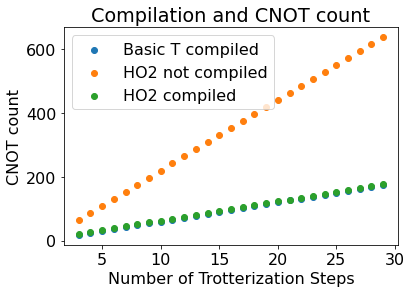

In [1212]:
x_axis = range(3, 30)
#plt.scatter(x_axis, qc_cxs, label = "Basic T not compiled")
plt.scatter(x_axis, tr_cxs, label = "Basic T compiled" )
#plt.scatter(x_axis, ti_cxs, label = "TIT not compiled" )
#plt.scatter(x_axis, tr_ti_cxs, label = "TIT compiled" )
plt.scatter(x_axis, ho2_cxs, label = "HO2 not compiled")
plt.scatter(x_axis, tr_ho2_cxs, label = "HO2 compiled" )

plt.title('Compilation and CNOT count')
plt.ylabel('CNOT count')
plt.xlabel("Number of Trotterization Steps")

plt.legend()

plt.show()

In [1214]:
steps_experiment(ti_higher_order_trotter(2), 10, backend = sim_noisy_jakarta, shuttle = True, compiler = True)

Job ID ced2de4f-a927-4abb-9b67-c74c2c56ec00
Job ID 91f9b886-b668-4c88-a049-4948b6b4b47c
Job ID 0dfad6f2-f118-40da-ade7-1887e6bb7d5c
state tomography fidelity = 0.1917 ± 0.0005
Job ID 44075c11-843a-4ce3-8801-27ef1ef6b60f
Job ID 8786cbac-f350-48a9-9f9d-c25abe03831d
Job ID 19091444-aabb-431f-8260-ad44c482eb92
state tomography fidelity = 0.3149 ± 0.0025
Job ID f8e14962-c2d7-4e4b-aff6-6980af518cb8
Job ID ed78a995-4b0e-4822-9784-a35e4b22c074
Job ID 68f66cbf-1690-4238-87d7-ddff3951491c
state tomography fidelity = 0.4032 ± 0.0019
Job ID 8365018e-e6df-4079-be46-86861fd43b93
Job ID f1dc098d-bde1-4699-96f8-96a75198e16a
Job ID a773abba-6843-4699-b22b-63253a8a9b77
state tomography fidelity = 0.4360 ± 0.0043
Job ID f812da0e-5d4f-48c3-a861-6b9907f9984a
Job ID 42c0f032-d241-4d93-ab6d-0ba56094f9eb
Job ID acda0917-192a-4750-9d2e-4a3c1ffdf43f
state tomography fidelity = 0.4398 ± 0.0013
Job ID ed134e7f-a014-4da7-9d65-ce7a5444cdd9
Job ID 193cbd4d-5884-4bc7-820a-fccd600cf606
Job ID 1b982f6f-8fc7-4f62-872c-c

([4, 5, 6, 7, 8, 9],
 [0.19166178299382516,
  0.3149270490159098,
  0.40324223970195455,
  0.4359672998333121,
  0.4398065948019682,
  0.43136581799059814])

In [1195]:
steps_experiment(ti_trotter, 10, backend = sim_noisy_jakarta, compiler = False, shuttle = True)

Job ID 25956502-327d-4d56-a0d9-cb907c8bbcf6
Job ID 3c8fc34a-0904-421c-a200-96c7e040b176
Job ID cbe4da07-85f6-4808-9008-49a5ef43c5c8
state tomography fidelity = 0.0375 ± 0.0007
Job ID 1cfd5dd9-14cc-4c12-9769-57f587b8025e
Job ID 966c83bd-4d78-4c5e-ae33-7b803f2054fc
Job ID 74f9b086-90d2-4c27-95d2-17d6418da5d0
state tomography fidelity = 0.1786 ± 0.0021
Job ID b2feb7b5-9a48-4ce5-a280-864349ef7e90
Job ID 87530eea-96a2-4b22-93f9-de2442cdc170
Job ID 70ab27c9-2e2f-445c-8623-dc72d3689cac
state tomography fidelity = 0.2998 ± 0.0030
Job ID 059398b0-bf3e-4108-bcab-888ff56ef1f8
Job ID 2062ea92-91d0-478c-9c24-0d909457b013
Job ID 1adbaf8b-fa01-407d-8234-f818a6891c3d
state tomography fidelity = 0.3479 ± 0.0023
Job ID 57a97da6-01d6-4abc-a899-f9206ab0eb8b
Job ID ef9ceda2-2f78-4d07-a077-e979636d2f49
Job ID b0b575b8-5418-4279-ac14-445d2005e8b7
state tomography fidelity = 0.3505 ± 0.0039
Job ID 484e98cb-107c-4c1e-8718-cc78152aab71
Job ID 48f365ca-9b3a-4a38-8f09-b9b2a3620ff0
Job ID 2be9daa2-ad47-40c5-889a-0

([4, 5, 6, 7, 8, 9],
 [0.03752149250153702,
  0.17858159463003612,
  0.2998245264170944,
  0.34786379991816435,
  0.350482773173183,
  0.33671374940539534])

In [1697]:
steps_experiment(ti_trotter, 10, backend = sim_noisy_jakarta, compiler = True, shuttle = True)

Circuit Description  OrderedDict([('cx', 57), ('rz', 24), ('ry', 16), ('u2', 16), ('rx', 16), ('u3', 4)])
Job ID 9b6dd078-6679-4fbc-923e-b337d910c6b3
Job ID be928c5a-898e-49e7-aeb2-5e4c89ea5a96
Job ID 00611734-1339-40fd-bae9-640a9b095d98
state tomography fidelity = 0.0371 ± 0.0014
Circuit Description  OrderedDict([('cx', 69), ('rz', 30), ('ry', 20), ('u2', 20), ('rx', 20), ('u3', 4)])
Job ID 1c9d6ea3-9c0e-4649-9f5e-56e9939c7751
Job ID ab102323-da8a-43c0-9485-08d094a8863c
Job ID 9863e8e9-8505-4900-96e4-210e3f1fb768
state tomography fidelity = 0.1847 ± 0.0003
Circuit Description  OrderedDict([('cx', 81), ('rz', 36), ('ry', 24), ('u2', 24), ('rx', 24), ('u3', 4)])
Job ID 0543103d-1afa-4e98-977e-8c11a4a23022
Job ID fe523e3f-2bd5-4d1d-b667-7ee33aa79279
Job ID 63059ee8-7e0f-4e8e-9f51-a376dba0e1d0
state tomography fidelity = 0.3093 ± 0.0030
Circuit Description  OrderedDict([('cx', 93), ('rz', 42), ('ry', 28), ('u2', 28), ('rx', 28), ('u3', 4)])
Job ID 29966638-6e26-4a12-b496-b77a2b31fe2f
Job 

([4, 5, 6, 7, 8, 9],
 [0.03711709300718851,
  0.18466299582084292,
  0.30927337953778444,
  0.35623919627600703,
  0.36139905044029025,
  0.3488296408404152])

In [1715]:
steps_experiment(ti_higher_order_trotter(2), 10, n_min = 4,  backend = sim_noisy_jakarta, compiler = True, shuttle = True)

Circuit Description  OrderedDict([('cx', 45), ('rz', 18), ('ry', 12), ('u2', 12), ('rx', 12), ('u3', 4), ('unitary', 3)])
Job ID 514cc185-5df4-4bfc-8d85-e13a36960b28
Job ID a5135a55-a6c3-4da6-8e84-38d5c9c04ed4
Job ID 4091b70b-6097-47f0-9000-b7045a2e7ffe
state tomography fidelity = 0.1910 ± 0.0016
Circuit Description  OrderedDict([('cx', 51), ('rz', 21), ('ry', 14), ('u2', 14), ('rx', 14), ('u3', 4), ('unitary', 4)])
Job ID 431ef8f6-4ac6-4a83-93a5-47b001f5985a
Job ID 1861d0c4-1ad8-4d56-a4d0-131bfcc7dd73
Job ID 8ddde043-6a6b-44f7-86ed-770495eed38d
state tomography fidelity = 0.3009 ± 0.0031
Circuit Description  OrderedDict([('cx', 57), ('rz', 24), ('ry', 16), ('u2', 16), ('rx', 16), ('unitary', 5), ('u3', 4)])
Job ID cc493bcf-59e9-4a3d-986c-8c6e92804b50
Job ID ba75657b-79a7-49de-b2c5-11850c29dab4
Job ID f2ffc60f-ffac-4931-800b-9892dd16bffb
state tomography fidelity = 0.3799 ± 0.0034
Circuit Description  OrderedDict([('cx', 63), ('rz', 27), ('ry', 18), ('u2', 18), ('rx', 18), ('unitary', 

([4, 5, 6, 7, 8, 9],
 [0.19101874403941074,
  0.3008904633704017,
  0.37987638530568923,
  0.4093510947354418,
  0.41676530501184567,
  0.40377567450087753])

In [1716]:
steps_experiment(ti_higher_order_trotter(2), 10, n_min = 4, qsd = True,  backend = sim, compiler = True, shuttle = True)

Circuit Description  OrderedDict([('cx', 26), ('u3', 23), ('rz', 6), ('ry', 2), ('unitary', 1)])
Job ID 0641f11a-109a-496f-b477-b1507649af42
Job ID e628238d-63b9-4062-94e8-e5d51e6b5366
Job ID 3a59e811-42ca-4b08-b917-3976f8eae8fa
state tomography fidelity = 0.2482 ± 0.0026
Circuit Description  OrderedDict([('cx', 26), ('u3', 22), ('rz', 8), ('unitary', 2), ('ry', 2)])
Job ID 0eccb0fc-8f66-4217-9505-2527f141ae14
Job ID abcde83c-d8da-4466-be52-f8d4de290903
Job ID cbfa35fd-cc30-4deb-bc37-468b02c8c58e
state tomography fidelity = 0.4881 ± 0.0031
Circuit Description  OrderedDict([('cx', 26), ('u3', 22), ('rz', 8), ('unitary', 2), ('ry', 2)])
Job ID 617ba89c-a300-4261-9351-c2305f0d7a40
Job ID 1eead1f2-fab8-47b2-b0f3-845f252ed065
Job ID e7b87863-8b7d-471e-8c79-e811757a86aa
state tomography fidelity = 0.6807 ± 0.0009
Circuit Description  OrderedDict([('cx', 26), ('u3', 22), ('rz', 8), ('unitary', 2), ('ry', 2)])
Job ID b2977559-d457-4db6-80fe-63de83a32b7c
Job ID 6c817896-252d-490e-8f75-6d4375857

([4, 5, 6, 7, 8, 9],
 [0.24816250349413024,
  0.4881128359272271,
  0.6806820040584246,
  0.8051090614355388,
  0.877199335525806,
  0.9197709925979365])

In [621]:
steps_experiment(ti_higher_order_trotter(2), 10, n_min = 4, qsd = False,  backend = sim, compiler = True, shuttle = True)

Circuit Description  OrderedDict([('cx', 45), ('rz', 18), ('ry', 12), ('u2', 12), ('rx', 12), ('u3', 4), ('unitary', 3)])
Job ID acde6345-8caa-43ae-bec2-4247870f73d1
Job ID e32d9e8c-12a9-4355-ab6d-ad202614ed42
Job ID b568a17d-14ab-434e-bbab-a40d44ceab91
state tomography fidelity = 0.2489 ± 0.0012
Circuit Description  OrderedDict([('cx', 51), ('rz', 21), ('ry', 14), ('u2', 14), ('rx', 14), ('u3', 4), ('unitary', 4)])
Job ID afd66582-ce5b-4f42-8aed-eba07bb47b60
Job ID 8c75dc14-8674-4957-9d5d-8f5be4f95958
Job ID 4cda93ed-5253-4ee7-b0f1-25b189f242ec
state tomography fidelity = 0.4889 ± 0.0008
Circuit Description  OrderedDict([('cx', 57), ('rz', 24), ('ry', 16), ('u2', 16), ('rx', 16), ('unitary', 5), ('u3', 4)])
Job ID bc388cd8-5e65-44af-9937-8449b9b1c8ea
Job ID 2cde7e5c-2de0-4e63-86ef-f3c3b8c6851b
Job ID d0d4d911-41ca-4174-a5f6-7ca8e9a47f63
state tomography fidelity = 0.6809 ± 0.0005
Circuit Description  OrderedDict([('cx', 63), ('rz', 27), ('ry', 18), ('u2', 18), ('rx', 18), ('unitary', 

([4, 5, 6, 7, 8, 9],
 [0.24887279663703246,
  0.488865616548081,
  0.6809049855807978,
  0.8048145615640313,
  0.8786210440899677,
  0.9185112191940578])